In [1]:
import sys, os, json, pickle, gzip, copy, torch
sys.path.append('..')
import numpy as np
import gzip, pickle, numbers
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser
from src.feature import composition_to_feature
from pymatgen.core import Composition
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

# ELMD

In [27]:
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)
with gzip.open('../data/screened_precursor.pkl.gz','rb') as f:
    screened_precursor = pickle.load(f)
num_eles = np.zeros((len(ActiveElements), 2))

for data in unique_target:
    for ele, frac in data['target_comp'].items():
        i = ActiveElements.index(ele)
        num_eles[i, 0] += data['count']
for data in screened_precursor.values():
    for ele, frac in data['precursor_comp'].items():
        i = ActiveElements.index(ele)
        num_eles[i, 1] += data['count']

In [28]:
elmd = {}
for fn in os.listdir('../src/elmd'):
    if not fn.endswith('json'): continue
    elmd[fn.split('.')[0]] = json.load(open(f'../src/elmd/{fn}'))

for fn, data in sorted(elmd.items(), key=lambda x: x[0]):
    dtype = []
    dlen = []
#    ele_not_in_table = []
    for ele, feat in data.items():
        dtype.append(str(type(feat)).split()[1].replace('>','').replace('\'',''))
        if isinstance(feat, (int, float)):
            dlen.append(1)
        else:
            dlen.append(len(feat))
#    for ele in elmd['atomic'].keys():
#        if ele not in data.keys() and ele not in 'DTUue':
#            ele_not_in_table.append((ele, Element(ele).number))
    ele_not_in_data = {}
    for i, ele in enumerate(ActiveElements):
        if ele not in data.keys() and num_eles[i].sum() != 0:
            ele_not_in_data[ele] = num_eles[i, :]
    print(fn, dtype[0], dlen[0], len(dtype))
#    print(ele_not_in_table)
    if len(ele_not_in_data) != 0:
        print(ele_not_in_data)
#    print(ele_not_in_table)
#    print()
    

atomic int 1 121
cgcnn list 91 100
elemnet list 135 98
jarvis list 438 82
{'Eu': array([1633., 1619.]), 'Np': array([11.,  8.]), 'Pu': array([26., 24.]), 'Am': array([4., 0.]), 'Cm': array([1., 0.])}
jarvis_sc list 438 82
{'Eu': array([1633., 1619.]), 'Np': array([11.,  8.]), 'Pu': array([26., 24.]), 'Am': array([4., 0.]), 'Cm': array([1., 0.])}
magpie list 21 97
magpie_sc list 22 97
mat2vec list 199 118
matscholar list 200 103
megnet16 list 16 95
{'Am': array([4., 0.]), 'Cm': array([1., 0.])}
mendeleev int 1 121
mod_petti int 1 121
oliynyk list 44 85
{'Np': array([11.,  8.]), 'Pu': array([26., 24.]), 'Am': array([4., 0.]), 'Cm': array([1., 0.])}
oliynyk_sc list 44 85
{'Np': array([11.,  8.]), 'Pu': array([26., 24.]), 'Am': array([4., 0.]), 'Cm': array([1., 0.])}
petti int 1 121
random_200 list 200 82
{'Eu': array([1633., 1619.]), 'Np': array([11.,  8.]), 'Pu': array([26., 24.]), 'Am': array([4., 0.]), 'Cm': array([1., 0.])}


In [21]:
len(ActiveElements)

97


# Composition featurization functions

In [114]:
with gzip.open('../data/unique_ligand.pkl.gz','rb') as f:
    unique_ligand = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)

In [115]:
from src.feature import composition_to_feature

composition_to_feature({'Li':0.2, 'Co':0.2, 'O':0.6}, feature_type='magpie')

array([[6.4000000e+01, 2.2774479e+01, 4.7721799e+02, 1.1600000e+01,
        2.4000001e+00, 9.0400002e+01, 2.6359999e+00, 1.8000000e+00,
        2.4000001e+00, 1.4000000e+00, 0.0000000e+00, 5.5999999e+00,
        2.0000000e-01, 1.2000000e+00, 6.0000002e-01, 0.0000000e+00,
        2.0000000e+00, 1.0830667e+01, 0.0000000e+00, 3.0969423e-01,
        9.1800003e+01]], dtype=float32)

In [15]:
fgs = {}
mask = np.ones(len(unique_precursor), dtype=bool)
for ele in MetalElements:
    precs = []
    for i, prec in enumerate(unique_precursor):
        if ele not in prec['precursor_comp'].keys(): continue
        precs.append([len(prec['years']), prec['precursor_comp']])
        mask[i] = False
    precs = sorted(precs, key=lambda x: x[0], reverse=True)
    precs = sorted(precs, key=lambda x: len(list(x[1].keys())))
    precs = sorted(precs, key=lambda x: tuple(list(x[1].keys())))
    for prec in precs:
        n = np.min(list(prec[1].values()))
        p = '   '.join([f'{e:2s}:{f/n:.2f}' for e, f in prec[1].items()])
        print('{:5d} : {}'.format(prec[0], p))
    if len(prec) != 0:
        print()

precs = []
for j in np.where(mask)[0]:
    prec = unique_precursor[j]
    precs.append([len(prec['years']), prec['precursor_comp']])
            
precs = sorted(precs, key=lambda x: x[0], reverse=True)
precs = sorted(precs, key=lambda x: len(list(x[1].keys())))
precs = sorted(precs, key=lambda x: tuple(list(x[1].keys())))
for prec in precs:
    n = np.min(list(prec[1].values()))
    p = '   '.join([f'{e:2s}:{f/n:.2f}' for e, f in prec[1].items()])
    print('{:5d} : {}'.format(prec[0], p))


   90 : Li:1.00
   22 : Li:1.00   Br:1.00
 3589 : Li:2.00   C :1.00   O :3.00
   57 : Li:1.00   C :1.00   O :3.00
    1 : Li:1.00   C :1.00   O :2.00
   28 : Li:1.00   Cl:1.00
  129 : Li:1.00   F :1.00
   22 : Li:1.00   H :1.00
  124 : Li:1.00   H :3.00   C :2.00   O :2.00
   21 : Li:1.00   H :2.00   N :1.00
  706 : Li:1.00   H :1.00   O :1.00
    1 : Li:1.00   H :2.00   S :1.00   N :1.00   O :3.00
    1 : Li:2.00   H :2.00   S :1.00   O :5.00
    1 : Li:1.00   I :1.00
   24 : Li:3.00   N :1.00
  138 : Li:1.00   N :1.00   O :3.00
  130 : Li:2.00   O :1.00
   26 : Li:1.00   O :1.00
    2 : Li:3.00   P :1.00
    1 : Li:1.00   P :2.33
   78 : Li:1.00   P :1.00   H :2.00   O :4.00
   47 : Li:3.00   P :1.00   O :4.00
    4 : Li:1.67   P :1.00   O :3.33
    4 : Li:1.40   P :1.00   O :3.20
    3 : Li:2.00   P :1.00   O :3.50
    2 : Li:1.00   P :1.00   O :3.00
    1 : Li:3.00   P :1.00   S :4.00
    1 : Li:6.00   P :1.00   S :5.00   Br:1.00
    1 : Li:4.00   P :1.00   Se:2.50   S :2.00
    1

In [18]:
fgs = {}
for prec in unique_precursor:
    n = len(prec['years'])
    metals = {}
    non_metals = {}
    for e, f in prec['precursor_comp'].items():
        if e in MetalElements:
            metals.update({e:f})
        else:
            non_metals.update({e:f})
    k_m = tuple(sorted(list(metals.keys()), key=lambda x: Element(x).number))
    k_fg = tuple(sorted(list(non_metals.keys()), key=lambda x: Element(x).number))
    if k_fg not in fgs.keys():
        fgs[k_fg] = {'count':0, 'metals':{}}
    if k_m not in fgs[k_fg]['metals']:
        fgs[k_fg]['metals'][k_m] = {
            'count':0, 'case':[]
        }
    fgs[k_fg]['count'] += n
    fgs[k_fg]['metals'][k_m]['count'] += n
    fgs[k_fg]['metals'][k_m]['case'].append([prec['precursor_comp'], n])

In [31]:
fgs = {k:v for k,v in sorted(fgs.items(), key=lambda x: len(x[0]))}
fgs = {k:v for k,v in sorted(fgs.items(), key=lambda x: x[0])}
fgs = {k:v for k,v in sorted(fgs.items(), key=lambda x: x[1]['count'])}
for k, v in fgs.items():
    m = list(v['metals'].keys())
    print(k, v['count'], f'{len(m)}/{len(MetalElements)}')
    print(m)
    print()

('C', 'N', 'S') 1 1/87
[()]

('H', 'C', 'N') 1 1/87
[()]

('H', 'C', 'N', 'Br') 1 1/87
[('Pb',)]

('H', 'O', 'Cl') 1 1/87
[('Sr',)]

('H', 'O', 'Se') 1 1/87
[()]

('H', 'S') 1 1/87
[()]

('O', 'F') 1 1/87
[('Tm',)]

('O', 'I') 1 1/87
[('Bi',)]

('O', 'P', 'Cl') 1 1/87
[('Ca',)]

('P', 'S', 'Br') 1 1/87
[('Li',)]

('S', 'Se') 1 1/87
[('Sn',)]

('H', 'C') 2 1/87
[()]

('H', 'C', 'N', 'Cl') 2 2/87
[(), ('Pb',)]

('H', 'C', 'N', 'I') 2 2/87
[(), ('Pb',)]

('H', 'C', 'N', 'O') 2 1/87
[()]

('H', 'C', 'N', 'O', 'P') 2 1/87
[('Fe',)]

('H', 'F') 2 1/87
[('Si',)]

('C', 'S') 3 2/87
[('Nb',), ('W',)]

('H', 'C', 'N', 'S') 3 1/87
[()]

('H', 'Cl') 3 2/87
[(), ('Au',)]

('N', 'P') 3 1/87
[()]

('O', 'F', 'P') 3 1/87
[('Na',)]

('P', 'S', 'Se') 3 2/87
[('Li',), ('Mg',)]

('H', 'C', 'S', 'Br') 4 1/87
[()]

('H', 'C', 'S', 'Cl') 4 1/87
[()]

('O', 'Br') 5 2/87
[('Pb',), ('Bi',)]

('H', 'C', 'S', 'I') 6 1/87
[()]

('H', 'N', 'Br') 6 1/87
[()]

('H', 'O', 'S') 14 3/87
[(), ('Ca',), ('Li',)]

('C', 'N'

# Precursor dataset 

In [3]:
DS = ReactionDataset()
DS.from_file('../data/screened_unique_reaction.pkl.gz')

embedding 및 label 관리를 위해 따로 만들 필요가 있음

In [15]:
#완성 후 삭제함
from src.feature import PrecursorDataset
PDS = PrecursorDataset()

### precursor mask

In [92]:
mat = np.zeros((PDS.NUM_LABEL, len(MetalElements)+1), dtype=bool)
for i, prec in enumerate(PDS.precursor_source):
    for ele in prec['precursor_comp'].keys():
        if ele in MetalElements:
            j = MetalElements.index(ele)
            mat[i, j] = True
    if mat[i].sum() == 0:
        mat[i, -1] = True
mat = mat.T

In [93]:
z = np.matmul(mat.T, mat)

In [138]:
k = -1
js = np.where(mat[k])[0]
print(MetalElements[k] if k != -1 else 'None', mat[k].sum())
print(js)
for i, j in enumerate(js):
    print('{:2d} {:4d} {:2d}  {}'.format(i, j, int(((z[j] & mat[k]) != mat[k]).sum() == 0), PDS.precursor_source[j]['precursor_comp']))
#np.where(z[0]), np.where(z[43]), np.where(z[180])

None 20
[ 26  34  44  75  83  97 104 136 175 212 232 255 269 280 302 353 362 367
 407 421]
 0   26  1  {'Se': 1.0}
 1   34  1  {'S': 1.0}
 2   44  1  {'P': 0.083333336, 'H': 0.5, 'N': 0.083333336, 'O': 0.33333334}
 3   75  1  {'P': 0.0625, 'H': 0.5625, 'N': 0.125, 'O': 0.25}
 4   83  1  {'P': 1.0}
 5   97  1  {'P': 0.2857143, 'O': 0.71428573}
 6  104  1  {'C': 1.0}
 7  136  1  {'P': 0.125, 'H': 0.375, 'O': 0.5}
 8  175  1  {'H': 0.6666667, 'N': 0.16666667, 'Cl': 0.16666667}
 9  212  1  {'H': 0.6666667, 'N': 0.16666667, 'F': 0.16666667}
10  232  1  {'Se': 0.33333334, 'O': 0.6666667}
11  255  1  {'I': 1.0}
12  269  1  {'H': 0.6666667, 'C': 0.22222222, 'O': 0.11111111}
13  280  1  {'P': 0.2857143, 'S': 0.71428573}
14  302  1  {'H': 0.53333336, 'S': 0.06666667, 'N': 0.13333334, 'O': 0.26666668}
15  353  1  {'P': 0.2857143, 'Se': 0.71428573}
16  362  1  {'P': 0.05, 'H': 0.6, 'N': 0.15, 'O': 0.2}
17  367  1  {'H': 0.2857143, 'S': 0.14285715, 'O': 0.5714286}
18  407  1  {'H': 0.6666667, 'Br':

In [129]:
mat[-1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [91]:
for j in np.where(mat[:, k])[0]:
    print(PDS.precursor_source[j]['precursor_comp'])

{'Se': 1.0}
{'S': 1.0}
{'P': 0.083333336, 'H': 0.5, 'N': 0.083333336, 'O': 0.33333334}
{'P': 0.0625, 'H': 0.5625, 'N': 0.125, 'O': 0.25}
{'P': 1.0}
{'P': 0.2857143, 'O': 0.71428573}
{'C': 1.0}
{'P': 0.125, 'H': 0.375, 'O': 0.5}
{'H': 0.6666667, 'N': 0.16666667, 'Cl': 0.16666667}
{'H': 0.6666667, 'N': 0.16666667, 'F': 0.16666667}
{'Se': 0.33333334, 'O': 0.6666667}
{'I': 1.0}
{'H': 0.6666667, 'C': 0.22222222, 'O': 0.11111111}
{'P': 0.2857143, 'S': 0.71428573}
{'H': 0.53333336, 'S': 0.06666667, 'N': 0.13333334, 'O': 0.26666668}
{'P': 0.2857143, 'Se': 0.71428573}
{'P': 0.05, 'H': 0.6, 'N': 0.15, 'O': 0.2}
{'H': 0.2857143, 'S': 0.14285715, 'O': 0.5714286}
{'H': 0.6666667, 'Br': 0.16666667, 'N': 0.16666667}
{'H': 0.625, 'N': 0.125, 'F': 0.25}


In [4]:
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    dataset = pickle.load(f)
pstrs = []
for data in dataset:
    for prec in data['precursor_comp']:
        pstr = composit_parser(prec)
        if pstr not in pstrs:
            pstrs.append(pstr)
PDS.update(pstrs)


In [5]:
for j in np.where(PDS.precursor_mask[-1])[0]:
    print(j, PDS.label_to_precursor[j])

26 Se_1.00000
34 S_1.00000
44 H_0.50000 N_0.08333 O_0.33333 P_0.08333
75 H_0.56250 N_0.12500 O_0.25000 P_0.06250
83 P_1.00000
97 O_0.71429 P_0.28571
104 C_1.00000
136 H_0.37500 O_0.50000 P_0.12500
175 H_0.66667 N_0.16667 Cl_0.16667
212 H_0.66667 N_0.16667 F_0.16667
232 O_0.66667 Se_0.33333
255 I_1.00000
269 H_0.66667 C_0.22222 O_0.11111
280 P_0.28571 S_0.71429
302 H_0.53333 N_0.13333 O_0.26667 S_0.06667
353 P_0.28571 Se_0.71429
360 H_0.60000 N_0.15000 O_0.20000 P_0.05000
364 H_0.28571 O_0.57143 S_0.14286
395 H_0.66667 N_0.16667 Br_0.16667
403 H_0.62500 N_0.12500 F_0.25000
412 EOS


In [41]:

def get_precursor_mask_from_target(self, target):
    mask = self.precursor_mask[-1].copy()
    for ele in target.keys():
        if ele in MetalElements:
            mask = mask | self.precursor_mask[MetalElements.index(ele)]
    return mask

target = dataset[0]['target_comp']
mask = get_precursor_mask_from_target(PDS, target)
print(target)
for j in np.where(mask)[0]:
#    print(j)
    out = PDS.get_precursor_info(j)[1]
    if isinstance(out, dict):
        print(out['precursor_comp'])
    else:
        print(out)
    #['precursor_comp']
#PDS.label_to_precursor[j]
#PDS.get_precursor_info(9)


{'Y': 0.0020005717, 'Al': 0.054872826, 'Si': 0.37153473, 'N': 0.5144327, 'O': 0.057159193}
{'Y': 0.4, 'O': 0.6}
{'Si': 0.33333334, 'O': 0.6666667}
{'Al': 0.4, 'O': 0.6}
{'Se': 1.0}
{'S': 1.0}
{'Al': 1.0}
{'P': 0.083333336, 'H': 0.5, 'N': 0.083333336, 'O': 0.33333334}
{'Si': 1.0}
{'P': 0.0625, 'H': 0.5625, 'N': 0.125, 'O': 0.25}
{'Si': 0.42857143, 'N': 0.5714286}
{'P': 1.0}
{'Al': 0.14285715, 'H': 0.42857143, 'O': 0.42857143}
{'P': 0.2857143, 'O': 0.71428573}
{'C': 1.0}
{'Al': 0.5, 'N': 0.5}
{'Y': 1.0}
{'P': 0.125, 'H': 0.375, 'O': 0.5}
{'Al': 0.07692308, 'N': 0.23076923, 'O': 0.6923077}
{'Y': 0.07692308, 'N': 0.23076923, 'O': 0.6923077}
{'H': 0.6666667, 'N': 0.16666667, 'Cl': 0.16666667}
{'Si': 0.16666667, 'H': 0.33333334, 'O': 0.5}
{'H': 0.6666667, 'N': 0.16666667, 'F': 0.16666667}
{'Al': 0.25, 'F': 0.75}
{'Si': 0.5, 'C': 0.5}
{'Se': 0.33333334, 'O': 0.6666667}
{'I': 1.0}
{'H': 0.6666667, 'C': 0.22222222, 'O': 0.11111111}
{'P': 0.2857143, 'S': 0.71428573}
{'H': 0.53333336, 'S': 0.0666

### precursor mask의 적합성 확인

In [14]:
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    dataset = pickle.load(f)

In [6]:
for data in dataset:
    m = np.zeros((len(MetalElements), 2), dtype=int)
    for ele in data['target_comp'].keys():
        if ele not in MetalElements: continue
        i = MetalElements.index(ele)
        m[i,0] += 1 
    for prec in data['precursor_comp']:
        for ele in prec.keys():
            if ele not in MetalElements: continue
            i = MetalElements.index(ele)
            m[i,1] += 1
    i, j = m.sum(0)
    if (i != j) and (np.sum(m[:, 1][m[:, 0] != 0] == 0) != 0):
        print(m[m[:, 1] != 0].T)

# target에 있는 모든 metal element는 precursor에 포함되어 있음.
# precursor에 있는 모든 metal element는 target에 포함되어 있음.

### Precursor 유사도

In [430]:
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    dataset = pickle.load(f)
    
labels = []
coprecursorset = []
for d in dataset:
    precursor_set = {}
    for p in d['precursor_comp']:
        pstr = composit_parser(p)
        if pstr not in PDS.precursor_to_label.keys(): continue
        labels.append(PDS.precursor_to_label[pstr])
        metal = [e for e in p.keys() if e in MetalElements]
        if len(metal) == 0:
            continue
        else:
            metal = metal[0]
        if metal not in precursor_set.keys():
            precursor_set[metal] = []
        precursor_set[metal].append(pstr)
    for v in precursor_set.values():
        if len(v) > 1:
            coprecursorset.append(v)

counts = np.zeros(500)
for i, c in zip(*np.unique(labels, return_counts=True)):
    counts[i] = c

In [434]:
np.unique([len(c) for c in coprecursorset], return_counts=True)

(array([2, 3, 4]), array([853,  65,   6]))

In [7]:
# active_precs = []
# for data in dataset:
#     for prec in data['precursor_comp']:
#         pstr = composit_parser(prec)
#         if pstr in active_precs:
#             continue
#         active_precs.append(pstr)
# PDS.update(active_precs)

In [71]:
from src.feature import MetalElements
k = 0
for i, mask in enumerate(PDS.precursor_mask):
    if mask.sum() == 0: continue
    js = np.where(mask)[0]
    k += 1
    #if i < len(MetalElements) and MetalElements[i] not in 'PuNp': continue
    if len(js) < 10: continue
    print(k, MetalElements[i] if i < len(MetalElements) else 'None', '-'*50)
    print(''.join([f'{j:4d}' for j in js]))
    print(''.join([f'{counts[j]:4.0f}' for j in js]))


1 Li --------------------------------------------------
  11  68 114 125 130 140 147 152 169 174 233 244 258 273 274 281 299 376
1886 344 112  96  87  75  71  66  48  45  24  23  20  18  18  17  15   8
4 Na --------------------------------------------------
  13  90 131 149 164 191 199 201 208 223 245 246 253 265 292 338 374 413
1757 163  87  68  53  37  32  31  29  27  23  23  21  19  16  11   8   6
5 Mg --------------------------------------------------
  18  55  82  88 167 177 196 249 313 375 399 409
1398 429 206 176  51  44  33  23  14   8   6   6
9 Ca --------------------------------------------------
   4  66 112 115 161 176 203 218 221 242 254 268 325 329 350 361
3774 349 114 112  56  45  30  27  27  23  21  19  12  12  10   9
14 Mn --------------------------------------------------
  15  35  38  54  71  84 120 179 234 248 278 294 337 351 401 405 440
1613 767 728 441 318 195 105  44  24  23  17  16  11  10   6   6   5
15 Fe --------------------------------------------------
   5

In [157]:
feat_types = ['composit', 'cgcnn', 'magpie_sc', 'mat2vec', 'matscholar', 'megnet16']
full_vectors = {ftype: np.vstack([composition_to_feature(prec['precursor_comp'], ftype) for prec in PDS.precursor_source]) for ftype in feat_types}
fg_vectors = {ftype: np.vstack([composition_to_feature({k:v for k,v in prec['precursor_comp'].items() if k not in MetalElements}, ftype) for prec in PDS.precursor_source]) for ftype in feat_types}
fgs = np.array([composit_parser({k:v for k,v in prec['precursor_comp'].items() if k not in MetalElements}) for prec in PDS.precursor_source])
element_source = [np.where(m)[0][0] if m.sum() != 0 else -1 for m in PDS.precursor_mask[:-1, :-2].T]

In [83]:
(fg_vectors['composit'] != 0).sum(0)

array([ 66,   0,   0,   0,  63,  58, 249,  28,   0,   0,   0,   0,  23,
        41,  23,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  14,   6,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   7,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [391]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE

labels = {}
for ftype in feat_types:
    for n_cluster in [10, 15, 20, 25]:        
        labels[f'{ftype}+full+{n_cluster}'] = []
        labels[f'{ftype}+fg+{n_cluster}'] = []
        for seed in range(1000):
            full_labels = KMeans(n_cluster, random_state=seed, n_init='auto').fit_predict(full_vectors[ftype])
            fg_labels = KMeans(n_cluster, random_state=seed, n_init='auto').fit_predict(fg_vectors[ftype])
            labels[f'{ftype}+full+{n_cluster}'].append(full_labels)
            labels[f'{ftype}+fg+{n_cluster}'].append(fg_labels)

In [392]:
def get_matrix(data, cutoff=50):
    matrix = np.zeros((len(data[0]), len(data[0])))
    for labels in data[:cutoff]:
        for i, label_i in enumerate(labels):
            for j, label_j in enumerate(labels[i+1:]):
                if label_i != label_j: continue
                matrix[i,i+j+1] += 1
                matrix[i+j+1,i] += 1
    return matrix

coassignment_matrices = {}
consensus_labels = {}
for ftype, label in labels.items():
    for n in [50, 100, 200, 500, 1000]:
        coassignment_matrices[f'{ftype}+{n}'] = get_matrix(label, n)
        agc = AgglomerativeClustering(n_clusters=8, metric='precomputed', linkage='average')
        consensus_labels[f'{ftype}+{n}'] = agc.fit_predict(1 - coassignment_matrices[f'{ftype}+{n}'] / n)

with open('../dump/coassignment_matrices.pkl','wb') as f:
    pickle.dump(coassignment_matrices, f)
with open('../dump/consensus_labels.pkl','wb') as f:
    pickle.dump(consensus_labels, f)

In [416]:
#plt.pcolormesh(coassignment_matrices['cgcnn+fg+10+100'])
mat = get_matrix(np.vstack([v for v in labels.values()]), cutoff=1000000)

In [417]:
with open('../dump/coassignment_matrix_all.pkl','wb') as f:
    pickle.dump(mat, f)

In [441]:
for i, (prec, count) in enumerate(zip(*np.unique(fgs, return_counts=True))):
    print(f'{i:3d} - {count:3d} : {prec:30s}')

  0 -  65 :                               
  1 -   3 : Br_0.50000                    
  2 -   2 : Br_0.66667                    
  3 -  11 : C_0.16667 O_0.50000           
  4 -  12 : C_0.20000 O_0.60000           
  5 -   4 : C_0.21429 O_0.64286           
  6 -   1 : C_0.22222 O_0.66667           
  7 -   4 : C_0.28571 O_0.57143           
  8 -   2 : C_0.30000 O_0.60000           
  9 -   1 : C_0.33333 N_0.33333           
 10 -   1 : C_0.42857                     
 11 -   3 : C_0.50000                     
 12 -   1 : C_1.00000                     
 13 -   8 : Cl_0.50000                    
 14 -  11 : Cl_0.66667                    
 15 -   1 : Cl_0.75000                    
 16 -   1 : Cl_0.83333                    
 17 -   4 : F_0.50000                     
 18 -   9 : F_0.66667                     
 19 -  12 : F_0.75000                     
 20 -   1 : F_0.80000                     
 21 -   1 : H_0.08000 C_0.16000 O_0.56000 
 22 -   1 : H_0.13333 C_0.13333 O_0.53333 
 23 -   1 :

In [426]:
agc = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='average')
label = agc.fit_predict(1 - mat / mat.max())


In [446]:
a, b = 0.23529, 0.70588
c = 1 - a - b
1, 4, 12



0.23529411764705882

In [427]:
np.unique(label, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 79,  81,  62, 195,  26]))

In [393]:
with open('../dump/coassignment_matrices.pkl','rb') as f:
    coassignment_matrices = pickle.load(f)
with open('../dump/consensus_labels.pkl','rb') as f:
    consensus_labels = pickle.load(f)

In [412]:
print(np.unique(consensus_labels['composit+full+20+500'], return_counts=True))
print(np.unique(consensus_labels['composit+full+20+1000'], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 96,  53,   7, 200,  22,  11,  28,  26]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 64, 189,  96,  22,  26,  28,   7,  11]))


In [388]:
print(np.unique(consensus_labels['composit+fg+10+50'], return_counts=True))
print(np.unique(consensus_labels['composit+fg+10+1000'], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 21,  13,  60, 197,  33,  86,   7,  26]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 21,  13,   8, 197,  33,  85,  60,  26]))


In [368]:
consensus_labels['composit+fg+10+50'][consensus_labels['composit+fg+10+1000'] == 3]


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [387]:
from scipy.optimize import linear_sum_assignment

def align_labels(labels_1, labels_2, num_clusters=8):
    cost_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            cost_matrix[i, j] = np.sum((labels_1 == i) & (labels_2 == j))
    _, col_ind = linear_sum_assignment(-cost_matrix)
    new_labels_2 = np.zeros_like(labels_2)
    for i, idx in enumerate(col_ind):
        new_labels_2[labels_2 == i] = idx
    return new_labels_2

for desc_0 in consensus_labels.keys():
    labels_1 = consensus_labels[desc_0]
    prefix = '+'.join(desc_0.split('+')[:2])
    for desc, labels in consensus_labels.items():
        if desc == desc_0: continue
        if not desc.startswith(prefix): continue
#    if not desc.startswith('composit+full'):
#        continue
        labels_2 = align_labels(labels_1, labels)
        consensus_labels[desc] = labels_2

In [363]:
descs = consensus_labels.keys()
for desc_i in descs:
    prefix = '+'.join(desc_i.split('+')[:2])
    labels_i = consensus_labels[desc_i]
    for desc_j in descs:
        if not desc_j.startswith(prefix): continue
        labels_j = consensus_labels[desc_j]

#labels_3 = align_labels(labels_1, labels_2)



array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7])

### eos and sos

In [181]:
PDS.update(DS)
#PDS.source_to_label[DS[0].labels]

#PDS.label_to_precursor[412]
#PDS.source_to_label[DS[0].labels], DS[0].labels
PDS.get_precursor_data('SOS')

(444,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32))

In [65]:
import gzip, pickle
path = '../data/screened_precursor.pkl.gz'
with gzip.open(path, 'rb') as f:
    unique_precursor = pickle.load(f)
unique_precursor[:4]


[{'id': 0,
  'count': 8339,
  'count_rxn': 4850,
  'year': 1993,
  'precursor_str': 'O_0.66667 Ti_0.33333',
  'precursor_comp': {'Ti': 0.33333334, 'O': 0.6666667},
  'years': {1993: 4,
   1997: 8,
   1998: 36,
   1999: 76,
   2000: 70,
   2001: 95,
   2002: 97,
   2003: 133,
   2004: 179,
   2005: 170,
   2006: 206,
   2007: 252,
   2008: 159,
   2009: 166,
   2010: 147,
   2011: 198,
   2012: 267,
   2013: 265,
   2014: 302,
   2015: 355,
   2016: 460,
   2017: 334,
   2018: 352,
   2019: 350,
   2020: 169},
  'dois': ['10.1016/0927-7757(93)80176-f',
   '10.1016/s0025-5408(98)00014-2',
   '10.1016/s0955-2219(98)00448-8',
   '10.1016/s1359-6454(99)00141-x',
   '10.1016/s0025-5408(00)00307-x',
   '10.1016/s0167-577x(99)00190-1',
   '10.1016/s0921-4534(00)00052-6',
   '10.1016/s0025-5408(01)00747-4',
   '10.1016/s0921-5107(01)00704-8',
   '10.1016/s1359-6462(00)00567-4',
   '10.1016/s0924-4247(01)00791-9',
   '10.1016/s0167-577x(03)00128-9',
   '10.1016/s0169-4332(02)01057-7',
   '10.101

# Functional Group Dataset 

In [4]:
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reactions = pickle.load(f)
with gzip.open('../data/screened_precursor.pkl.gz','rb') as f:
    screened_precursor = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)    

In [404]:
import numpy as np
from src.feature import MetalElements, AllElements

class LigandTemplateDataset:
    def __init__(self, 
                 feat_type:str = 'composit',
                 by_fraction:bool = True,
                 *args, **kwargs):
        self._feat_type = feat_type
        self._by_fraction = by_fraction

#        path = os.path.join(os.path.dirname(os.path.abspath(__file__)), '../data/screened_precursor.pkl.gz')
        path = '../data/screened_precursor.pkl.gz'

        with gzip.open(path, 'rb') as f:
            self._precursor_source = pickle.load(f)
        self._active_precursors = [p['precursor_str'] for p in self._precursor_source]
        self._precursor_to_source = {c:i for i,c in enumerate(self._active_precursors)}
#        self._source_vecs = np.vstack([composition_to_feature(c) for c in self._active_precursors])
        self._metal_indexer = {'none': 0}
        self._metal_indexer.update({metal:i+1 for i,metal in enumerate(MetalElements)})
        self.update()

    def update(self, active_precursors=None):
        if not isinstance(active_precursors, (list, np.ndarray, tuple, set)):
            active_precursors = self._active_precursors
        _active_precursors = []
        self._ligand_dict = {}
        for i_src, precursor in enumerate(self._precursor_source):
            if precursor['precursor_str'] not in active_precursors:
                continue
            _active_precursors.append(precursor['precursor_str'])
            n_total = np.sum(list(precursor['precursor_comp'].values()))
            i_metal = 0
            non_metal = {}
            for ele, n in precursor['precursor_comp'].items():
                if ele in MetalElements:
                    i_metal = self._metal_indexer[ele]
                else:
                    non_metal[ele] = n/n_total
            ligand_str = composit_parser(non_metal)
            if ligand_str not in self._ligand_dict.keys():
                self._ligand_dict[ligand_str] = {
                    'label':None, 
                    'composition':non_metal,
                    'embedding': composition_to_feature(composit_dict = non_metal, 
                                                        feature_type = self._feat_type,
                                                        by_fraction = self._by_fraction,
                                                        norm=False).reshape(1,-1),
                    'metals':[]}
            self._ligand_dict[ligand_str]['metals'].append((i_metal, i_src))

        self.NUM_LABEL = len(self._ligand_dict)
        self._active_precursors = _active_precursors.copy()

        self._source_to_label = np.zeros((len(self._precursor_source), 2), dtype=int)
        self._label_to_source = - np.ones((len(MetalElements)+1, self.NUM_LABEL), dtype=int)
        self._ligand_str = list(self._ligand_dict.keys())
        for j, ligand_info in enumerate(self._ligand_dict.values()):
            ligand_info['label'] = j
            for i, i_source in ligand_info['metals']:
                self._label_to_source[i, j] = i_source
                self._source_to_label[i_source] = i, j

    def save(self, path, fn='precursor_data.json'):
        info = {
            'feat_type': self._feat_type,
            'by_fraction': self._by_fraction,
            'active_precursors': self._active_precursors,
        }
        with open(os.path.join(path, fn), 'w') as f:
            json.dump(info, f, indent=4)
    
    def load(self, path, fn='precursor_data.json'):
        with open(os.path.join(path, fn), 'r') as f:
            info = json.load(f)
        self.__init__(feat_type = info['feat_type'],
                      by_fraction = info['by_fraction'],
                      norm = info['norm'])
        self.update(info['active_precursors'])
        return self

    def _check_valid_precursor(self, *args, exit=True):
        i_src = None
        if len(args) == 1:
            if isinstance(args[0], dict):
                div = np.sum(list(args[0].values()))
                precursor = composit_parser({e:n/div for e,n in args[0].items()})
            elif isinstance(args[0], str):
                precursor = args[0]
            elif exit:
                raise ValueError('Precursor must be either `dict` or `str`, got', type(args[0]))
            try:
                i_src = self._precursor_to_source[precursor]
            except:
                i_src = None
        elif len(args) > 1:
            metal, ligand = args[:2]
            i_metal, i_ligand = None, None
            if isinstance(metal, str) and (metal in self._metal_indexer):
                i_metal = self._metal_indexer[metal]
            elif isinstance(metal, numbers.Integral) and metal < len(MetalElements) + 1:
                i_metal = metal
            if isinstance(ligand, str) and (ligand in self._ligand_dict.keys()):
                i_ligand = self._ligand_dict[ligand]['label']
            elif isinstance(ligand, numbers.Integral) and ligand < len(self._ligand_dict):
                i_ligand = ligand
            if (i_metal is None) or (i_ligand is None):
                i_src = None
            else:
                i_src = self._label_to_source[i_metal, i_ligand]
            if i_src == -1:
                i_src = None
        if (i_src is None) and exit:
            raise ValueError('Invalid precursor', args)
        return i_src        

    def to_label(self, *args):
        i_source = self._check_valid_precursor(args)
        _, label = self._source_to_label[i_source]
        return label

    def get_embedding(self, *args):
        i_src = self._check_valid_precursor(args, exit=False)
        if i_src is None:
            return composition_to_feature({}, feature_type=self._feat_type, by_fraction=self._by_fraction)
        else:
            _, i_ligand = self._source_to_label[i_src]
            return self._ligand_dict[self._ligand_str[i_ligand]]['embedding']
    
    def get_info(self, *args):
        i_source = self._check_valid_precursor(*args)
        return self._precursor_source[i_source]
    
    def get_mask(self, metal):
        if metal in MetalElements:
            i_metal = MetalElements.index(metal) + 1
        else:
            i_metal = 0
        return (self._label_to_source[i_metal] != -1).reshape(1,-1)

    def to_dict(self):
        return {
            'feature_type': self._feat_type, 
            'NUM_LABEL': self.NUM_LABEL,
        }

In [405]:
test = LigandTemplateDataset()
#test.update([p['precursor_str'] for p in screened_precursor])

In [411]:
np.repeat(test.get_embedding(), 4, axis=0).shape

(4, 88)

In [396]:
np.where(test._label_to_source[0] != -1)

(array([  8,  10,  11,  15,  19,  22,  24,  33,  41,  47,  51,  59,  64,
         71,  76,  88,  90,  91, 103, 107]),)

In [266]:
#mask[0]
metals, mask = test.get_ligand_mask_from_target({'Ti':0.111, 'Li':0.3333, 'Co':0.3333, 'O':0.666667})
for mele, m in zip(metals, mask):
    for (ligand, metal), active in zip(test._ligand_dict.items(), m):
        if not active: continue
        print(mele in [_m[0] for _m in metal['metals']], mele, '   {:3f}   '.format(np.sum(list(metal['composition'].values()))), ligand)

True Ti    0.666667    O_0.66667
True Ti    0.600000    O_0.60000
True Ti    0.000000    
True Ti    0.750000    O_0.75000
True Ti    0.500000    C_0.50000
True Ti    0.666667    S_0.66667
True Ti    0.888889    H_0.44444 O_0.44444
True Li    0.800000    C_0.20000 O_0.60000
True Li    0.500000    O_0.50000
True Li    0.666667    C_0.16667 O_0.50000
True Li    0.000000    
True Li    0.666667    H_0.33333 O_0.33333
True Li    0.333333    O_0.33333
True Li    0.800000    N_0.20000 O_0.60000
True Li    0.500000    F_0.50000
True Li    0.875000    H_0.37500 C_0.25000 O_0.25000
True Li    0.333333    S_0.33333
True Li    0.875000    H_0.25000 O_0.50000 P_0.12500
True Li    0.625000    O_0.50000 P_0.12500
True Li    0.500000    Cl_0.50000
True Li    0.250000    N_0.25000
True Li    0.500000    H_0.50000
True Li    0.750000    H_0.50000 N_0.25000
True Li    0.500000    Br_0.50000
True Li    0.714286    O_0.57143 S_0.14286
True Co    0.800000    C_0.20000 O_0.60000
True Co    0.600000    O_0.6

### how to manage?

In [42]:

count_precursor = {}
for data in unique_reactions:
    for p in data['precursor_comp']:
        comp = Composition(p)
        new_comp = str(Composition(comp.get_integer_formula_and_factor()[0]))
        if new_comp not in count_precursor.keys():
            count_precursor[new_comp] = 0
        count_precursor[new_comp] += 1

prec_comps = []
for prec in screened_precursor:
    comp = Composition(prec['precursor_comp'].items())
    new_comp = Composition(comp.get_integer_formula_and_factor()[0]).as_dict()
    prec_comps.append(new_comp)
    for e, f in new_comp.items():
        if e not in MetalElements: continue
        if f != 1: print(new_comp)

{'La': 2.0, 'O': 3.0}
{'Fe': 2.0, 'O': 3.0}
{'Bi': 2.0, 'O': 3.0}
{'Nb': 2.0, 'O': 5.0}
{'Y': 2.0, 'O': 3.0}
{'Li': 2.0, 'C': 1.0, 'O': 3.0}
{'Al': 2.0, 'O': 3.0}
{'Na': 2.0, 'C': 1.0, 'O': 3.0}
{'Eu': 2.0, 'O': 3.0}
{'Co': 3.0, 'O': 4.0}
{'Gd': 2.0, 'O': 3.0}
{'Ga': 2.0, 'O': 3.0}
{'Ta': 2.0, 'O': 5.0}
{'Nd': 2.0, 'O': 3.0}
{'Cr': 2.0, 'O': 3.0}
{'Sm': 2.0, 'O': 3.0}
{'Mn': 2.0, 'O': 3.0}
{'V': 2.0, 'O': 5.0}
{'Pr': 6.0, 'O': 11.0}
{'Co': 2.0, 'O': 3.0}
{'In': 2.0, 'O': 3.0}
{'Tb': 4.0, 'O': 7.0}
{'Sc': 2.0, 'O': 3.0}
{'Dy': 2.0, 'O': 3.0}
{'Yb': 2.0, 'O': 3.0}
{'Lu': 2.0, 'O': 3.0}
{'B': 2.0, 'O': 3.0}
{'Sb': 2.0, 'O': 3.0}
{'Er': 2.0, 'O': 3.0}
{'Ho': 2.0, 'O': 3.0}
{'Si': 3.0, 'N': 4.0}
{'Mg': 5.0, 'H': 2.0, 'C': 4.0, 'O': 14.0}
{'Mn': 3.0, 'O': 4.0}
{'Sb': 2.0, 'O': 5.0}
{'Ag': 2.0, 'O': 1.0}
{'Cu': 2.0, 'O': 1.0}
{'Pb': 3.0, 'O': 4.0}
{'Fe': 3.0, 'O': 4.0}
{'Cs': 2.0, 'C': 1.0, 'O': 3.0}
{'Pr': 2.0, 'O': 3.0}
{'Li': 2.0, 'O': 1.0}
{'Mo': 7.0, 'H': 24.0, 'N': 6.0, 'O': 24.0}
{'Rh'

In [74]:
fgs_int = {}
fgs_norm_full  = {}
fgs_norm_metal = {}
for p in prec_comps:
    pstr = str(Composition(p))
    pc = count_precursor[pstr]
    ns = 0
    metal_n = 1
    others = {}
    metal = 'none'
    metal_ele = 'none'
    for e,n in p.items():
        ns += n
        if e in MetalElements:
            metal = f'{e}{n:.0f}'
            metal_ele = e
            metal_n = n
        else:
            others[e] = n    
    norm_by_metal = {k:v/metal_n for k,v in others.items()}
    norm_by_all = {k:v/ns for k,v in others.items()}
    intkey = str(Composition(others))
    mfrkey = str(Composition(norm_by_metal))
    frkey = str(Composition(norm_by_all))

    if intkey not in fgs_int.keys():
        fgs_int[intkey] = []
    if frkey not in fgs_norm_full.keys():
        fgs_norm_full[frkey] = []
    if mfrkey not in fgs_norm_metal.keys():
        fgs_norm_metal[mfrkey] = []
    fgs_int[intkey].append((metal, pc))
    fgs_norm_full[frkey].append((metal_ele, pc))
    fgs_norm_metal[mfrkey].append((metal_ele, pc))    

In [48]:
metal_int = {}
metal_fr = {}
for e in MetalElements:
    metal_int[e] = {}
    metal_fr[e] = {}
    for prec in prec_comps:
        if e not in prec.keys():
            continue
        ns = np.sum([v for v in prec.values()])
        mc = [v for e,v in prec.items() if e in MetalElements][0]
        prec_str = str(Composition(prec))
        fg_int = str(Composition({e:v for e,v in prec.items() if e not in MetalElements}))
        fg_fr  = str(Composition({e:v/ns for e,v in prec.items() if e not in MetalElements}))
        if fg_int not in metal_int[e].keys():
            metal_int[e][fg_int] = [0, []]
        if fg_fr not in metal_fr[e].keys():
            metal_fr[e][fg_fr] = [0, []]
        metal_int[e][fg_int][0] += count_precursor[prec_str]
        metal_int[e][fg_int][1].append(mc)
        metal_fr[e][fg_fr][0] += count_precursor[prec_str]
        metal_fr[e][fg_fr][1].append(mc)
    if len(metal_int[e]) > 1:
        print(e, '-' * 50)
        for p, (c, mcs) in metal_int[e].items():
            print(f'    {p:15s} : {c:4d} / {mcs}')

Li --------------------------------------------------
    C1 O3           : 1931 / [2.0, 1.0]
    H1 O1           :  344 / [1.0]
    N1 O3           :  112 / [1.0]
    F1              :   96 / [1.0]
    O1              :   87 / [2.0]
    H3 C2 O2        :   75 / [1.0]
    S1              :   71 / [2.0]
                    :   66 / [1.0]
    P1 H2 O4        :   48 / [1.0]
    P1 O4           :   24 / [3.0]
    Cl1             :   23 / [1.0]
    N1              :   20 / [3.0]
    H1              :   18 / [1.0]
    H2 N1           :   18 / [1.0]
    Br1             :   17 / [1.0]
    O2              :   15 / [2.0]
    S1 O4           :    8 / [2.0]
Be --------------------------------------------------
                    :   28 / [1.0]
    O1              :   11 / [1.0]
B --------------------------------------------------
    O3              :  311 / [2.0]
    H3 O3           :  259 / [1.0]
                    :  111 / [1.0]
    H2 O7           :   12 / [2.0]
Na --------------------------

In [657]:
import re
num = re.compile(r'\d')
for data_dict in [fgs_int, fgs_norm_full, fgs_norm_metal]:
    for fg, metals in data_dict.items():
        for i, (metal_i, c_i) in enumerate(metals):
            ele_i = num.sub('', metal_i)
            for j, (metal_j, c_j) in enumerate(metals[i+1:]):
                ele_j = num.sub('', metal_j)
                if ele_i == ele_j:
                    print(fg, '-', metal_i, c_i, metal_j, c_j)
    print('--')

C1 O3 - Sr1 4453 Sr2 23
C1 O3 - Ba1 4297 Ba2 31
C1 O3 - Ca1 3774 Ca2 27
C1 O3 - Li2 1886 Li1 45
C1 O3 - Na2 1757 Na1 53
O3 - Mo1 971 Mo2 12
O3 - Cr2 763 Cr1 24
O3 - Mn2 728 Mn1 16
O3 - Ti2 44 Ti1 5
O3 - Re1 9 Re2 8
O1 - Cu1 1696 Cu2 114
S1 - Cu2 27 Cu1 8
P1 - Fe1 8 Fe2 6
--
--
--


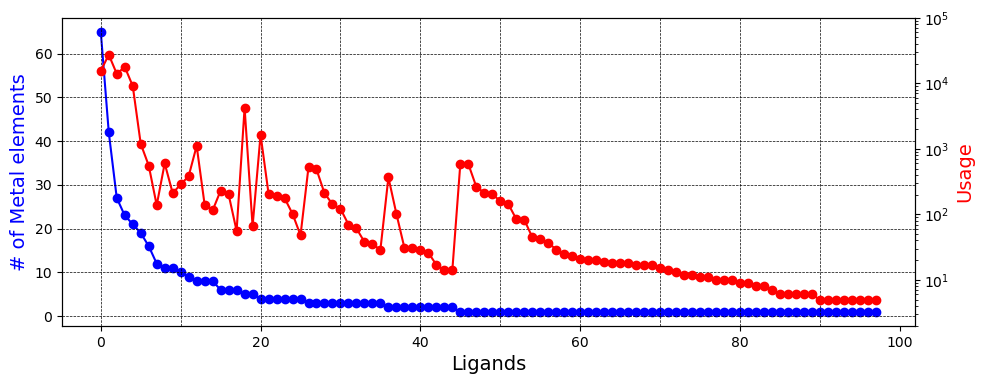

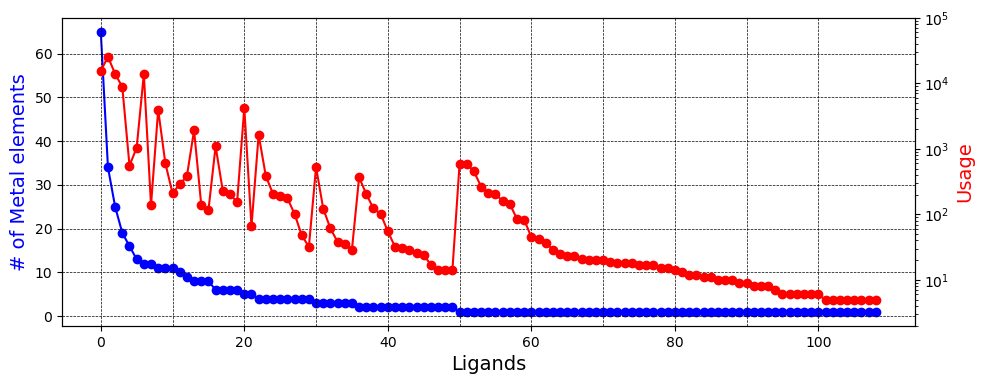

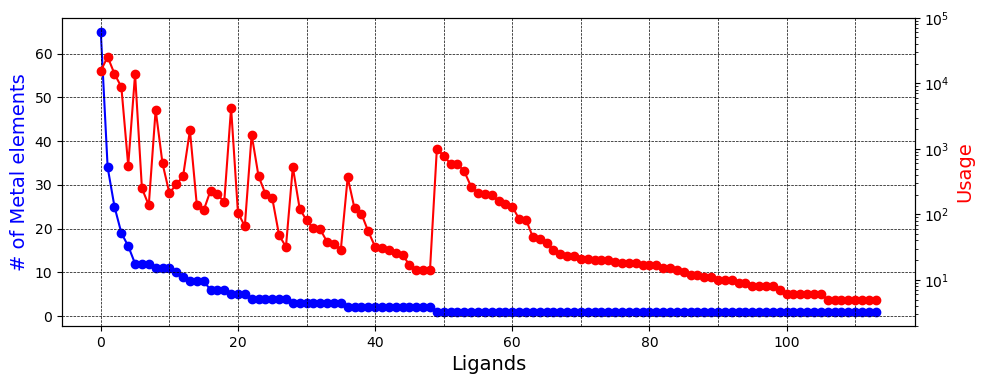

In [126]:
def draw_by_fg(ax, data):
    fgs, n_metals, n_precs = np.array([[fg, len(metals), np.sum([m[1] for m in metals])] for fg, metals in data.items()]).T
    n_precs = n_precs.astype(float)
    n_metals = n_metals.astype(float)
    o1 = np.argsort(n_precs)[::-1]
    o = sorted(o1, key=lambda x: n_metals[x], reverse=True)
    x = np.arange(len(n_metals))
    ax2 = ax.twinx()
    ax.plot(x, n_metals[o], '-o', color='b')
    for i in range(0, len(n_metals), 10):
        ax.axvline(i, ls='--', color='k', lw=0.5)
    for i in range(0,70,10):
        ax.axhline(i, ls='--', color='k', lw=0.5)
    ax2.plot(x, n_precs[o], '-o', color='r')
    ax2.set_yscale('log')
    ax2.set_ylim([2, 1e5])
    ax.set_xlabel('Ligands', fontsize=14)
    ax.set_ylabel('# of Metal elements', fontsize=14, color='b')
    ax2.set_ylabel('Usage', fontsize=14, color='r')


f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_fg(ax, fgs_int)
f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_fg(ax, fgs_norm_metal)
f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_fg(ax, fgs_norm_full)

In [88]:
mat = np.zeros((len(MetalElements)+1, len(fgs_norm_full))) + 1e-4
for j, metals in enumerate(sorted(fgs_norm_full.values(), key=lambda x: len(x), reverse=True)):
    for metal, v in metals:
        if metal == 'none':
            i = 0
        else:
            i = MetalElements.index(metal) + 1
        mat[i,j] = v

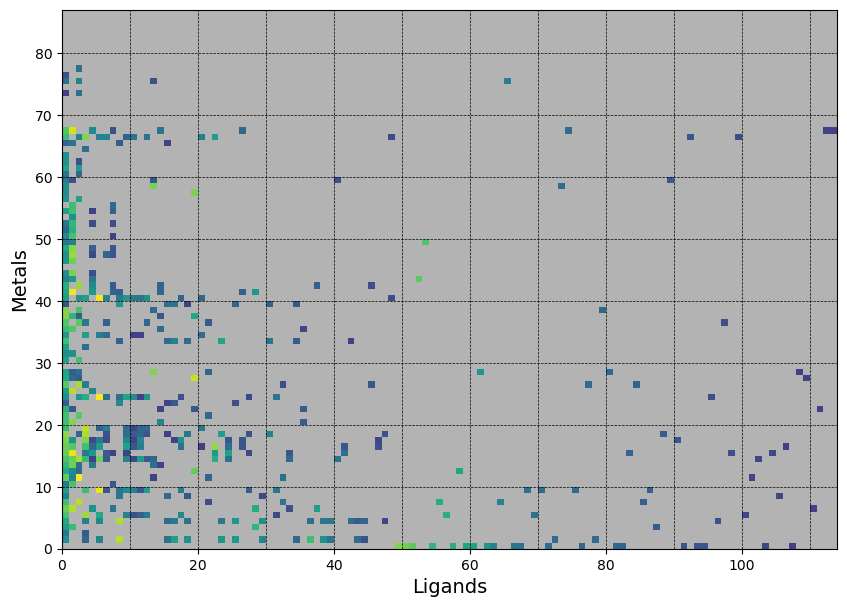

In [279]:
cmap = plt.get_cmap('viridis')
cmap.set_under([0.7,0.7,0.7])
f, ax = plt.subplots(1,1,figsize=(10,7))
ax.pcolormesh(np.log10(mat), cmap=cmap, vmin=0)
ax.set_ylabel('Metals', fontsize=14)
ax.set_xlabel('Ligands', fontsize=14)
for i in range(1, 12):
    ax.axvline(i * 10, ls='--', color='k', lw=0.5)
for i in range(1, 9):
    ax.axhline(i * 10, ls='--', color='k', lw=0.5)    

- 문제점
  - 금속 기준으로 normalize를 할 경우 metal-free precursor의 예측이 어려워짐
  - integer로 변경해서 사용 할 경우 큰 수가 나오는 경우가 있음 (200 이상)
- intrinsic한 parsing error로 인한 한계도 있음. 그냥 fractional로 진행


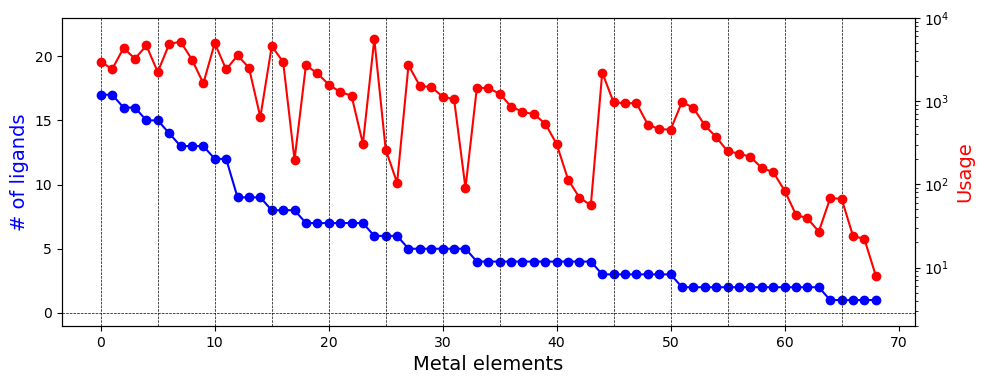

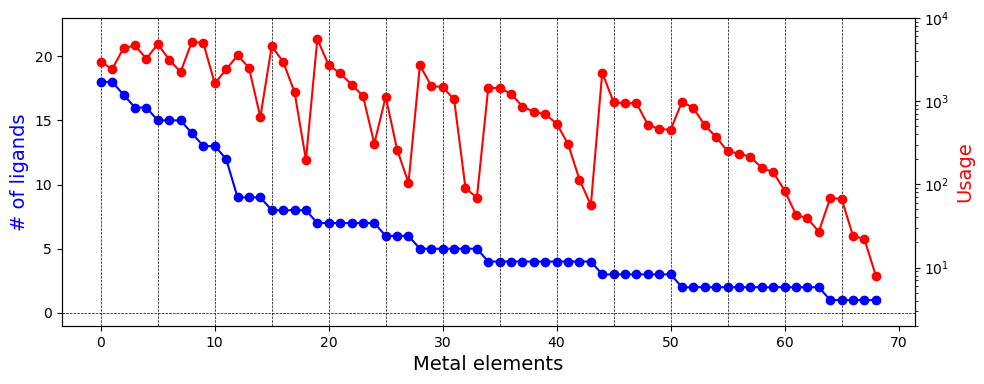

In [127]:

def draw_by_metal(ax, data):
    _, n_fgs, n_precs = np.array([[metal, len(fgs), np.sum([m[0] for m in fgs.values()])] for metal, fgs in data.items() if len(fgs) != 0]).T
    o1 = np.argsort(n_precs.astype(float))[::-1]
    o = sorted(o1, key=lambda x: n_fgs.astype(float)[x], reverse=True)

    x = np.arange(len(n_fgs))
    ax2 = ax.twinx()
    ax.plot(x, n_fgs.astype(float)[o], '-o', color='b')
    ax2.plot(x, n_precs.astype(float)[o], '-o', color='r')
    ax2.set_yscale('log')
    ax.set_ylim([-1,23])
    ax2.set_ylim([2, 1e4])
    for i in range(0, len(n_fgs), 5):
        ax.axvline(i, ls='--', color='k', lw=0.5)
    for i in range(0,2,5):
        ax.axhline(i, ls='--', color='k', lw=0.5)
    ax.set_ylabel('# of ligands', fontsize=14, color='b')
    ax.set_xlabel('Metal elements', fontsize=14)
    ax2.set_ylabel('Usage', fontsize=14, color='r')

f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_metal(ax, metal_int)
f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_metal(ax, metal_fr)
f.subplots_adjust(hspace=0)

# Data object test

In [1]:
import sys
sys.path.append('..')
import numpy as np
import torch, os, gzip, pickle
from src.data import ReactionData
from typing import Dict, List
from src.utils import ActiveElements, MetalElements, Element
from src.feature import composition_to_feature

with gzip.open('../data/screened_conditional_reaction.pkl.gz','rb') as f:
    cond_rxn = pickle.load(f)
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    uniq_rxn = pickle.load(f)

### speed test

In [44]:
def fnc1(x):
    return (x + 1) ** 3
def fnc2(x):
    return (x / 2 + 1) ** 0.5
def fnc3(x):
    return (x - 1) ** 2 / 2
def fnc4(x):
    return (x + 2) ** 2

def cfn1(n, x):
    d1 = []
    d2 = []
    d3 = []
    d4 = []
    for i in range(n):
        if x:
            v2 = fnc2(i)
            v1 = fnc1(i)
            d1.append(v1)
            d2.append(v2)
        if not x:
            v3 = fnc3(i)
            v4 = fnc4(i)
            d3.append(v3)
            d4.append(v4)
    return d1, d2, d3, d4

def cfn2(n, x):
    d1 = []
    d2 = []
    d3 = []
    d4 = []    
    if x:
        d1 = [fnc1(i) for i in range(n)]
        d2 = [fnc2(i) for i in range(n)]
    if not x:
        d3 = [fnc3(i) for i in range(n)]
        d4 = [fnc4(i) for i in range(n)]
    return d1, d2, d3, d4

%timeit cfn1(500, True)
%timeit cfn2(500, True)

124 µs ± 563 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
112 µs ± 750 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### check

In [96]:
cnt = 0
for i, rxn in enumerate(uniq_rxn):
    eles = {}
    for prec in rxn['precursor_comp']:
        metal_ele = tuple([e for e in prec.keys() if e in MetalElements])
        if metal_ele not in eles.keys():
            eles[metal_ele] = 0
        eles[metal_ele] += 1
#    if np.max(list(eles.values())) > 2:
#        print(i, eles)
    if tuple([]) in eles:
        cnt += 1
        print(i, eles)
print(cnt, len(uniq_rxn))



77 {('Ba',): 1, ('In',): 1, (): 1}
103 {(): 1, ('Sc',): 1, ('Li',): 1}
104 {(): 1, ('Sc',): 1, ('Li',): 1}
125 {(): 1, ('Sc',): 1, ('Zr',): 1, ('Li',): 1}
171 {('Ba',): 1, ('Cu',): 1, (): 1}
183 {('Zn',): 1, ('Ga',): 1, (): 1}
184 {('Zn',): 1, ('Ga',): 1, (): 1}
187 {(): 1, ('Na',): 1}
188 {(): 1, ('Na',): 1}
189 {('Na',): 1, (): 1}
190 {('Na',): 1, (): 1}
191 {('Na',): 1, (): 1}
192 {(): 1, ('Na',): 1}
198 {('Eu',): 1, (): 1}
201 {('Si',): 1, ('Mo',): 1, (): 1}
225 {(): 1, ('Ti',): 1, ('Si',): 1}
226 {(): 1, ('Ti',): 1, ('Si',): 1}
229 {('Ba',): 1, ('Co',): 1, (): 1}
230 {('Ba',): 1, ('Ni',): 1, (): 1}
243 {('V',): 1, ('Ba',): 1, (): 1}
244 {('V',): 1, ('Ba',): 1, (): 1, ('K',): 1}
245 {('V',): 1, ('Ba',): 1, (): 1, ('K',): 1}
246 {('V',): 1, ('Ba',): 1, (): 1, ('K',): 1}
247 {('V',): 1, ('Ba',): 1, (): 1, ('K',): 1}
255 {(): 1, ('Bi',): 1, ('Te',): 1}
280 {('Ir',): 1, (): 1, ('Cu',): 1}
281 {('Ir',): 1, ('Cu',): 1, (): 1}
299 {(): 1, ('Y',): 1}
521 {('Li',): 1, (): 1, ('Zr',): 1}
522

In [97]:
uniq_rxn[77]

{'id': 87,
 'count': 1,
 'year': 2010,
 'target_comp': {'Ba': 0.22222222, 'In': 0.22222222, 'O': 0.5555556},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6},
  {'In': 0.4, 'O': 0.6},
  {'P': 0.083333336, 'H': 0.5, 'N': 0.083333336, 'O': 0.33333334}],
 'dois': ['10.1039/c0cc00063a'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': [1273.15, 1573.15]}],
 'heat_time': [{'mean': None, 'median': None, 'raw': [10.0, 12.0, 50.0]}]}

In [89]:
uniq_rxn[29022 ]

{'id': 30178,
 'count': 1,
 'year': 2019,
 'target_comp': {'Na': 0.0023809525,
  'Sr': 0.23333333,
  'Eu': 0.0023809525,
  'P': 0.14285715,
  'O': 0.5714286,
  'F': 0.04761905},
 'precursor_comp': [{'Eu': 0.4, 'O': 0.6},
  {'Sr': 0.2, 'C': 0.2, 'O': 0.6},
  {'Na': 0.5, 'F': 0.5},
  {'H': 0.625, 'N': 0.125, 'F': 0.25},
  {'P': 0.083333336, 'H': 0.5, 'N': 0.083333336, 'O': 0.33333334}],
 'dois': ['10.1016/j.jallcom.2019.151906'],
 'heat_temp': [{'mean': None,
   'median': None,
   'raw': [573.0, 873.0, 1073.0, 573.0, 873.0, 1073.0]}],
 'heat_time': [{'mean': None, 'median': None, 'raw': [12.0, 12.0]}]}

In [91]:
uniq_rxn[7168 ]

{'id': 7555,
 'count': 1,
 'year': 2006,
 'target_comp': {'Ca': 0.21428572,
  'Nd': 0.023809524,
  'Si': 0.023809524,
  'P': 0.11904762,
  'O': 0.5714286,
  'F': 0.04761905},
 'precursor_comp': [{'Si': 0.33333334, 'O': 0.6666667},
  {'Ca': 0.18181819, 'P': 0.18181819, 'O': 0.6363636},
  {'Ca': 0.5, 'O': 0.5},
  {'Nd': 0.4, 'O': 0.6},
  {'Ca': 0.33333334, 'F': 0.6666667}],
 'dois': ['10.1016/j.jnucmat.2006.02.058'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': [1673.0]}],
 'heat_time': [{'mean': None, 'median': None, 'raw': [6.0]}]}

In [93]:
uniq_rxn[4]

{'id': 4,
 'count': 102,
 'year': 1988,
 'target_comp': {'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}],
 'dois': ['10.1007/bf00551283',
  '10.1016/s0925-8388(98)00766-x',
  '10.1016/s0025-5408(00)00382-2',
  '10.1016/s0025-5408(01)00751-6',
  '10.1016/s0304-8853(01)00288-8',
  '10.1016/s0304-8853(02)01387-2',
  '10.1016/j.jssc.2003.10.021',
  '10.1016/j.matlet.2004.05.017',
  '10.1016/s0304-8853(03)00559-6',
  '10.1016/s0304-8853(03)00586-9',
  '10.1016/j.jmmm.2004.07.033',
  '10.1016/j.matlet.2004.09.012',
  '10.1016/j.matlet.2005.01.072',
  '10.1016/j.powtec.2005.05.003',
  '10.1063/1.2058220',
  '10.1103/physrevb.72.104420',
  '10.1007/s10853-006-0921-y',
  '10.1016/j.jaap.2006.08.005',
  '10.1016/j.jmmm.2006.07.032',
  '10.1016/j.jmmm.2006.08.003',
  '10.1016/j.jmmm.2007.04.012',
  '10.1016/j.tsf.2007.03.013',
  '10.1007/s10854-007-9411-5',
  '10.1016/j.matlet.2007.09.073',
  '10.1002/pssa.200925104',
  '10.10

### Reaction data

In [2]:
data = uniq_rxn[0]
rxn_data = ReactionData(data = data,
                        feat_type = 'composit',
                        target_comp = data['target_comp'],
                        precursor_comps = data['precursor_comp'],
#                        conditions = ['heat_temp'],
#                        condition_values = [data['target_comp']['heat_temp']['median']],
                        weights = None)

rxn_data.precursor_feat

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
         0.0000, 0.0000, 0.3333, 0.0000, 0.

In [3]:
rxn_data.labels

tensor([[  9],
        [ 10],
        [117],
        [ 81]])

In [4]:
#rxn_data.metal_feat
#rxn_data.target_feat
for f in rxn_data.precursor_feat.numpy():
    ii = np.where(f)[0]
    print(ii, [(ActiveElements[i], f[i]) for i in ii])

[ 6 34] [('O', 0.6), ('Y', 0.4)]
[ 6 11] [('O', 0.6666667), ('Si', 0.33333334)]
[ 5 10] [('N', 0.5), ('Al', 0.5)]
[ 5 11] [('N', 0.5714286), ('Si', 0.42857143)]


In [5]:
rxn_data.precursor_feat[-1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5714, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.4286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

### Graph data

In [6]:
class GraphData(ReactionData):
    def __init__(self, 
                 data : Dict = {},
                 feat_type : str = 'composit',
                 target_comp : Dict = {},
                 precursor_comps : List[Dict] = [],
                 conditions : List[str] = [],
                 condition_values : List[float] = [],
                 weights : float = None,
                 *args, **kwargs):
        
        super().__init__(data = data,
                         feat_type = feat_type,
                         target_comp = target_comp,
                         precursor_comps = precursor_comps,
                         conditions = conditions,
                         condition_values = condition_values,
                         weights = weights,
                         *args, **kwargs)

        # graph 
        self._feature_attrs.extend(['edge_feat','edge_index'])
        edge_index = []
        edge_feat = []
        for i, metal_i in enumerate(self.metal_comp):
            for j, metal_j in enumerate(self.metal_comp):
                edge_index.append([i,j])
                if i == j:
                    edge_feat.append(self.target_feat)
                else:
                    edge_comp = {}
                    for e, f in self.target_comp.items():
                        if e in metal_i.keys() or e in metal_j.keys():
                            edge_comp.update({e:f})
                        elif e in MetalElements:
                            continue
                        elif len(metal_i) == 0 or len(metal_j) == 0:
                            edge_comp.update({e:f})
                    edge_feat.append(
                        composition_to_feature(composit_dict = edge_comp, 
                                               feature_type = feat_type, 
                                               by_fraction = True,
                                               norm = True)
                    )
        self.edge_index = np.array(edge_index, dtype=int).T
        self.edge_feat = np.vstack(edge_feat, dtype=np.float32)

### Sequence data

In [203]:
EOS_LABEL = 999
class SequenceData(ReactionData):
    def __init__(self, 
                 data : Dict = {},
                 feat_type : str = 'composit',
                 target_comp : Dict = {},
                 precursor_comps : List[Dict] = [],
                 conditions : List[str] = [],
                 condition_values : List[float] = [],
                 max_length : int = 8,
                 weights : float = None,
                 *args, **kwargs):
        super().__init__(data = data,
                         feat_type = feat_type,
                         target_comp = target_comp,
                         precursor_comps = precursor_comps,
                         conditions = conditions,
                         condition_values = condition_values,
                         weights = weights,
                         *args, **kwargs)
        
        self._feature_attrs.pop(self._feature_attrs.index('metal_feat'))
        delattr(self, 'metal_feat')
        self.n = max_length

        # labels & precursor feat
        pad = composition_to_feature({}, feature_type=feat_type)
        if hasattr(self, 'precursor_feat'):
            self.m = self.labels.shape[0]
            self.precursor_feat = np.vstack([
                pad.reshape(1,-1), self.precursor_feat, *[pad] * max_length
            ])[:max_length]
            self.labels = np.hstack([
                self.labels.reshape(-1), [EOS_LABEL] * max_length
            ])[:max_length].astype(int)
        else:
            self._feature_attrs.append('precursor_feat')
            self.precursor_feat = pad.reshape(1,-1)
        self.to_torch()

    def shuffle(self):
        if not hasattr(self, 'm'): 
            return
        j = np.random.permutation(self.m)
        i1 = np.arange(self.n)
        i2 = np.arange(self.n)
        i1[:self.m] = j
        i2[1:self.m+1] = j+1
        return self.precursor_feat[i2], self.labels[i1]

seq_data = SequenceData(data = data,
                        feat_type = 'composit',
                        target_comp = data['target_comp'],
                        precursor_comps = data['precursor_comp'],
#                        conditions = ['heat_temp'],
#                        condition_values = [data['target_comp']['heat_temp']['median']],
                        )
seq_data.precursor_feat.shape, seq_data.target_feat.shape, seq_data.labels
seq_data.shuffle()[1]

tensor([  9,  10,  81, 117, 999, 999, 999, 999])

In [215]:
from src.utils import composit_parser
check = {}
for i in range(10000):
    comp, lbl = seq_data.shuffle()
    for j, (c, l) in enumerate(zip(comp[1:].cpu().numpy(), lbl.cpu().numpy())):
        if l == 999: break
        pstr = composit_parser({ActiveElements[k]: c[k] for k in np.where(c)[0]})
        if pstr not in check.keys():
            check[pstr] = {'order':[0]*5}
        if l not in check[pstr].keys():
            check[pstr][l] = 0
        check[pstr][l] += 1
        check[pstr]['order'][j] += 1
check

{'O_0.66667 Si_0.33333': {'order': [2533, 2569, 2466, 2432, 0], 10: 10000},
 'N_0.57143 Si_0.42857': {'order': [2501, 2484, 2448, 2567, 0], 81: 10000},
 'O_0.60000 Y_0.40000': {'order': [2444, 2512, 2558, 2486, 0], 9: 10000},
 'N_0.50000 Al_0.50000': {'order': [2522, 2435, 2528, 2515, 0], 117: 10000}}

In [134]:
p = np.zeros(5)
x = np.array([
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
])
np.vstack([
    p, x, *[p] * 5
])

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [110]:
data['precursor_comp']

[{'Y': 0.4, 'O': 0.6},
 {'Si': 0.33333334, 'O': 0.6666667},
 {'Al': 0.5, 'N': 0.5},
 {'Si': 0.42857143, 'N': 0.5714286}]

# Dataset test

In [1]:
import sys
sys.path.append('..')
import numpy as np
import torch, os
from src.data import ReactionGraphDataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

## Dataset functions

In [2]:
#['cgcnn','elemnet','magpie','magpie_sc','mat2vec','matscholar','megnet16','oliynyk','oliynyk_sc']
ds = ReactionGraphDataset(feat_type='composit')
ds.from_file('../data/screened_conditional_reaction.pkl.gz', 
             heat_temp_key=('heat_temp', 'median'))
#ds.from_file('../data/surxn.pkl.gz')

In [12]:
ds.num_meta_feat + ds.has_temp_info + ds.has_time_info

89

In [3]:
i = 1900
for l,m in zip(ds[i].label, ds[i].label_mask):
    print(l[m], m.sum())
ds[i].to_dict()

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(12)
tensor([1, 0, 0, 0, 0, 0, 0, 0]) tensor(8)
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(13)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(17)


{'id': 1977,
 'id_urxn': 561,
 'count': 12,
 'doi': '10.1007/s10853-012-6966-1',
 'year': 1998,
 'year_doc': 2013,
 'data_type': 'basic',
 'feat_type': 'composit',
 'target_comp': {'Sr': 0.060000002, 'La': 0.14, 'Co': 0.2, 'O': 0.6},
 'precursor_comps': [{'Sr': 0.2, 'C': 0.2, 'O': 0.6},
  {'La': 0.4, 'O': 0.6},
  {'Co': 0.42857143, 'O': 0.5714286}],
 'heat_temp': 1373.15}

In [4]:
feat, info = ds.cfn(ds[80:90])

In [9]:
feat['condition_feat'].shape, feat['x'].shape

(torch.Size([30, 1]), torch.Size([30, 88]))

### collate_fnc design

In [10]:
def cfn(self, dataset):
    info = []
    rxn_id = []
    meta_feat = []
    edge_feat = []
    edge_index = []
    condition_feat = []
    prec_feat = []
    label = []
    label_mask = []
    weight = []
    n = 0
    for i, data in enumerate(dataset):
        info.append(data.to_dict())
        rxn_id.append([i] * data.n)
        meta_feat.append(data.meta_feat)
        edge_feat.append(data.edge_feat)
        edge_index.append(data.edge_index + n)
        n += data.n
    rxn_id = np.hstack(rxn_id).astype(int)
    meta_feat = torch.vstack(meta_feat).float()
    edge_feat = torch.vstack(edge_feat).float()
    edge_index = torch.vstack(edge_index).long()

    if self.has_temp_info or self.has_time_info:
        for data in dataset:
            condition_feat.append(data.condition_feat.repeat(data.n, 1))
        condition_feat = torch.vstack(condition_feat).float()

    if self._train:
        for data in dataset:
            prec_feat.append(data.precursor_feat)
            label.append(data.label)
            label_mask.append(data.label_mask)
            weight.append(data.weight.repeat(data.label.shape))
        prec_feat = torch.vstack(prec_feat)
        label = torch.vstack(label)
        label_mask = torch.vstack(label_mask)
        weight = torch.vstack(weight)

    return {
        'rxn_id' : rxn_id,
        'x' : meta_feat,
        'edge_attr' : edge_feat,
        'edge_index' : edge_index,
        'condition_feat' : condition_feat,
        'prec_feat' : prec_feat,
        'label' : label,
        'label_mask' : label_mask,
        'weight' : weight,
    }, info

feat, info = cfn(ds, ds[:50])

In [33]:
info = [d.to_dict() for d in ds]
info[88], info[89]

({'id': 90,
  'id_urxn': 4,
  'count': 91,
  'doi': '10.1111/jace.17161',
  'year': 1988,
  'year_doc': 2020,
  'data_type': 'basic',
  'feat_type': 'composit',
  'target_comp': {'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375},
  'precursor_comps': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}],
  'heat_temp': 1473.15},
 {'id': 92,
  'id_urxn': 6,
  'count': 2,
  'doi': '10.1016/s0304-8853(01)00811-3',
  'year': 2002,
  'year_doc': 2002,
  'data_type': 'basic',
  'feat_type': 'composit',
  'target_comp': {'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375},
  'precursor_comps': [{'Fe': 0.4, 'O': 0.6},
   {'Ba': 0.33333334, 'O': 0.6666667}],
  'heat_temp': 1353.15})

### weights?

In [34]:
stat = {}
for d in info:
    id = d['id_urxn']
    if id not in stat:
        stat[id] = {'count':d['count'], 'ids':[]}
    stat[id]['ids'].append(d['id'])

In [38]:
np.unique([len(v['ids']) - v['count'] for k, v in stat.items()], return_counts=True)

(array([-4, -3, -2, -1,  0]), array([    3,     3,    28,   181, 24294]))

In [40]:
for k, v in stat.items():
    if v['count'] - len(v['ids']) > 0:
        print(v['count'], len(v['ids']))

91 89
24 22
38 36
3 2
8 7
9 8
52 51
5 4
48 47
3 2
3 2
56 53
8 6
19 17
2 1
48 47
3 2
7 6
24 23
37 36
65 63
37 36
115 111
27 25
7 5
11 10
20 19
15 14
5 4
43 42
2 1
90 88
171 170
2 1
29 28
101 98
7 6
5 4
10 9
266 262
3 2
50 49
15 14
177 175
2 1
8 7
6 5
36 34
2 1
7 6
9 8
5 4
12 11
9 8
16 15
8 7
2 1
3 2
15 14
3 2
9 8
12 11
35 34
17 16
2 1
2 1
2 1
20 18
3 1
8 7
6 4
6 5
157 155
2 1
13 12
17 16
6 5
9 8
20 19
27 26
31 30
8 6
13 11
27 25
16 15
2 1
2 1
8 7
7 6
12 11
28 27
3 2
7 6
5 4
12 8
13 12
11 10
4 2
7 6
2 1
2 1
3 2
6 3
9 8
2 1
2 1
22 21
3 2
2 1
6 4
2 1
3 2
2 1
7 6
17 15
5 4
3 2
3 1
7 6
2 1
7 6
2 1
5 4
11 10
7 6
13 12
8 7
14 13
5 4
2 1
2 1
17 16
27 25
10 9
2 1
3 2
8 6
2 1
10 9
3 2
4 3
8 7
2 1
20 19
2 1
3 2
2 1
2 1
15 14
2 1
2 1
7 6
2 1
5 4
2 1
3 2
4 3
5 4
3 1
2 1
6 5
3 2
19 18
3 2
8 6
2 1
3 2
8 7
4 3
3 2
2 1
7 6
2 1
4 3
2 1
3 2
3 2
3 2
3 1
3 2
2 1
2 1
3 2
3 1
2 1
3 2
6 5
2 1
2 1
2 1
2 1
2 1
3 2
6 5
2 1
2 1
3 2
2 1
2 1
2 1
3 2
4 3
2 1
2 1
2 1
4 3
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1


### sequential dataset

In [31]:
# 완성 후 삭제함
cfn = ds.cfn

In [6]:
feat, info = cfn(ds, ds[:48])
#feat, info = ds.cfn(ds[:48])
for k,v in feat.items():
    print(k, v.shape)

target torch.Size([48, 7])
label torch.Size([336])
context torch.Size([48, 136])
weight torch.Size([336])
mask torch.Size([336])


In [22]:
embd = torch.stack([torch.ones(10) * i for i in range(445)])
embd[feat['target']]

tensor([[[443., 443., 443.,  ..., 443., 443., 443.],
         [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
         [  5.,   5.,   5.,  ...,   5.,   5.,   5.],
         ...,
         [444., 444., 444.,  ..., 444., 444., 444.],
         [444., 444., 444.,  ..., 444., 444., 444.],
         [444., 444., 444.,  ..., 444., 444., 444.]],

        [[443., 443., 443.,  ..., 443., 443., 443.],
         [  5.,   5.,   5.,  ...,   5.,   5.,   5.],
         [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
         ...,
         [444., 444., 444.,  ..., 444., 444., 444.],
         [444., 444., 444.,  ..., 444., 444., 444.],
         [444., 444., 444.,  ..., 444., 444., 444.]],

        [[443., 443., 443.,  ..., 443., 443., 443.],
         [  5.,   5.,   5.,  ...,   5.,   5.,   5.],
         [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
         ...,
         [444., 444., 444.,  ..., 444., 444., 444.],
         [444., 444., 444.,  ..., 444., 444., 444.],
         [444., 444., 444.,  ..., 444., 444., 444.]],

In [59]:
embed = torch.nn.Embedding(445, 10, padding_idx=444)
#embed.to('cuda')
#embed = embed.from_pretrained(embd)
embed.padding_idx

444

## check features


### feature

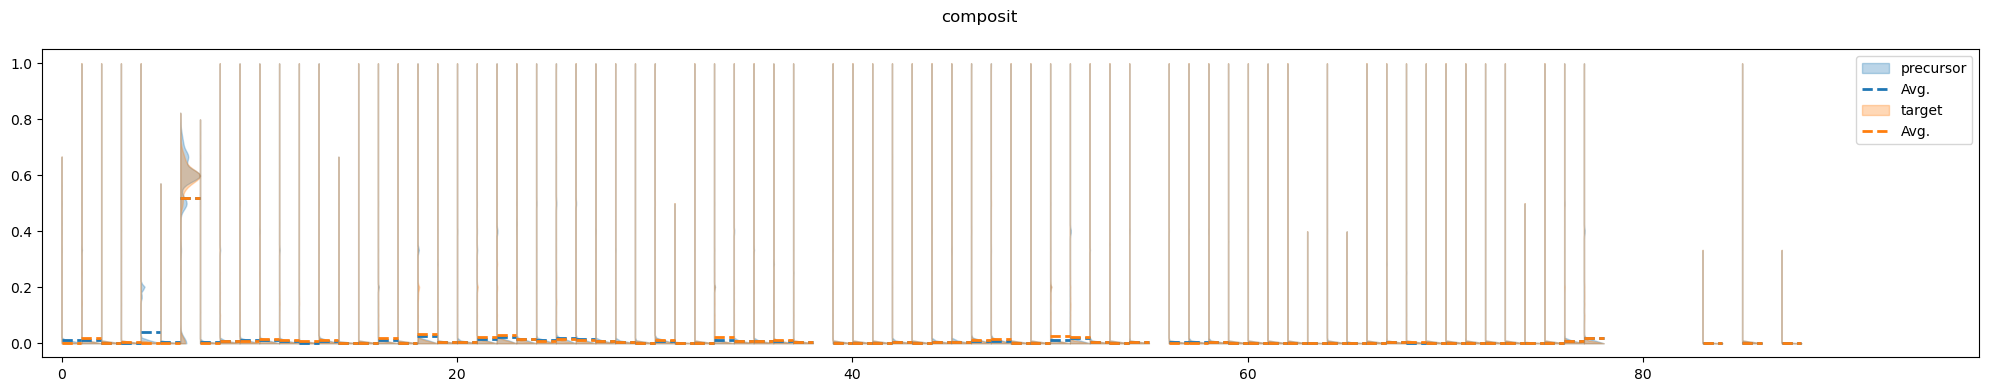

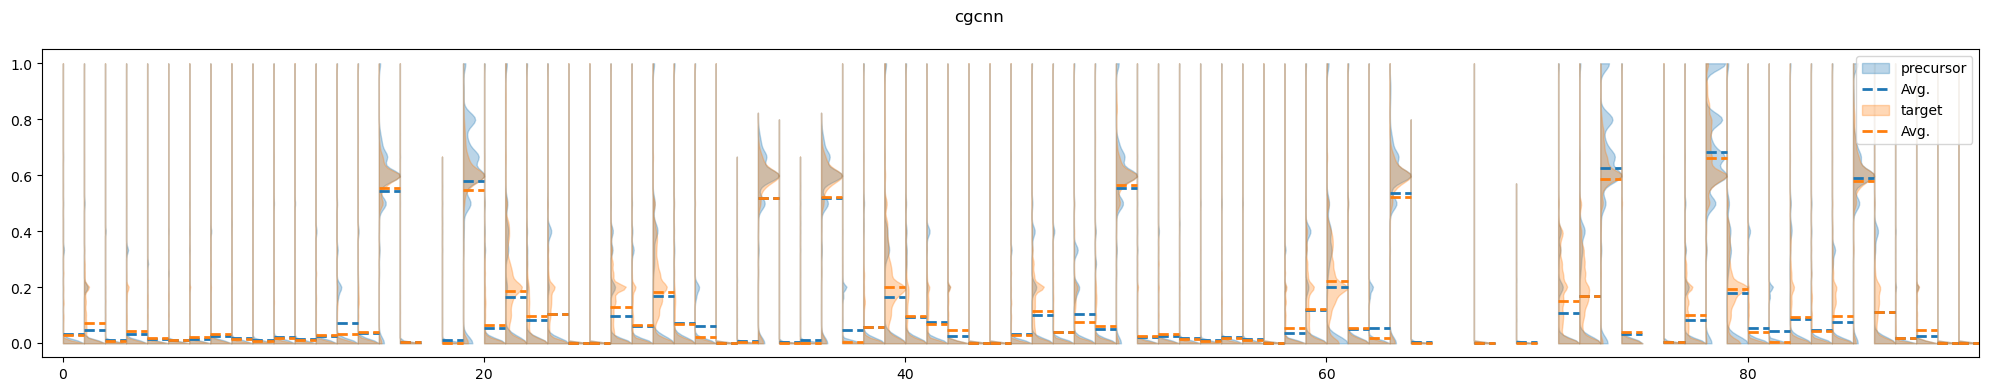

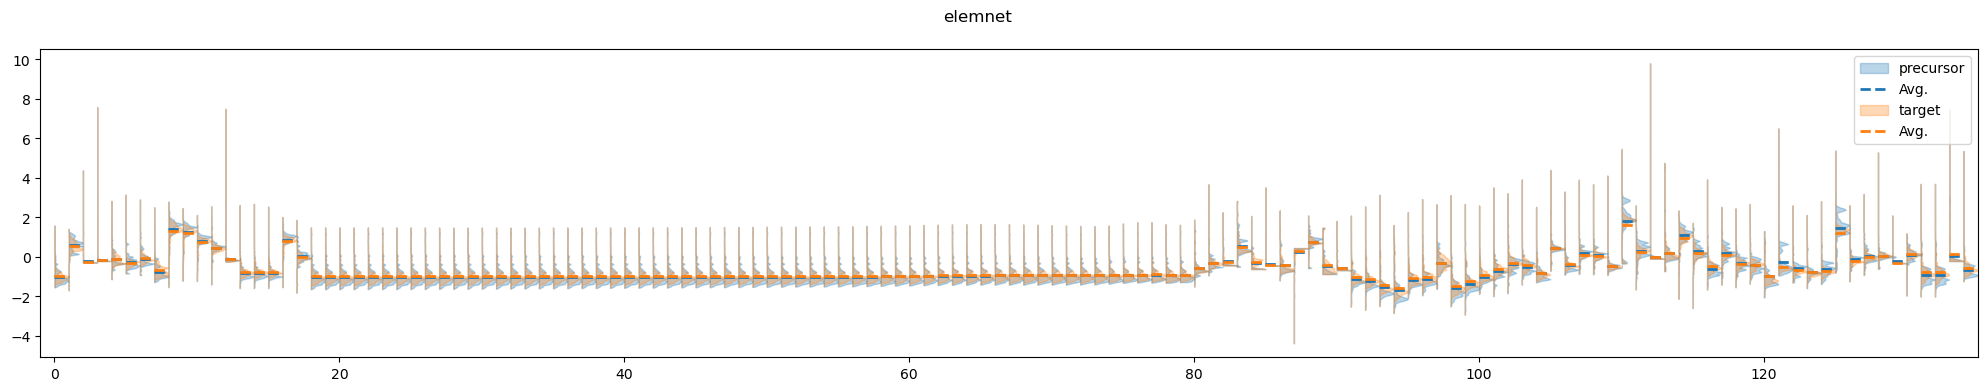

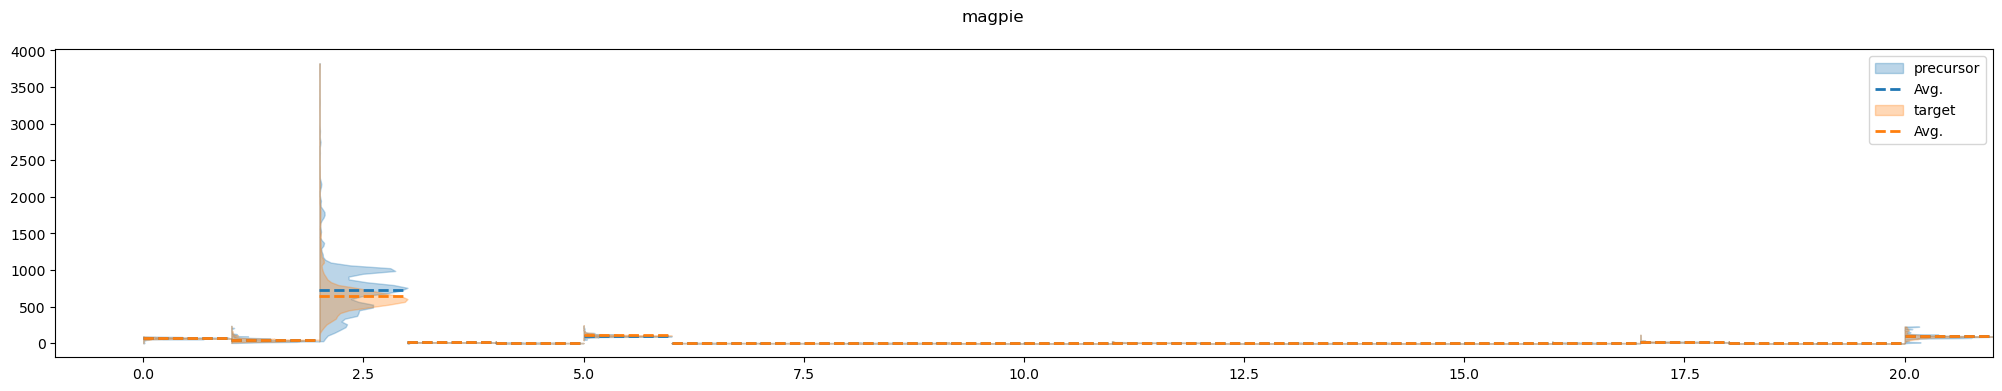

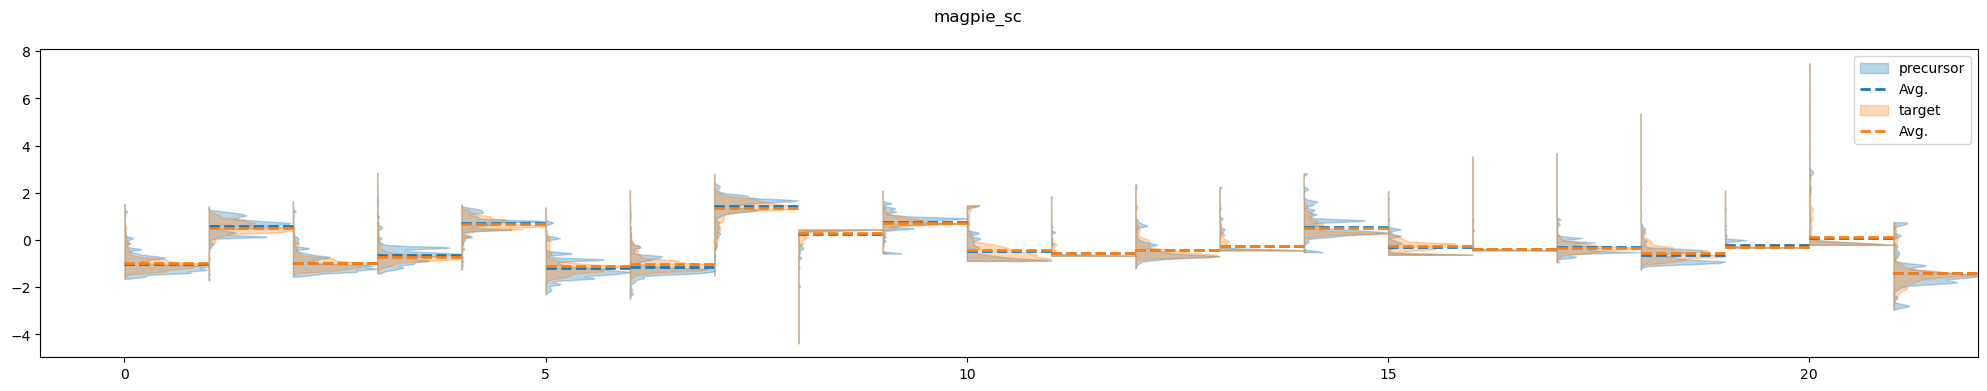

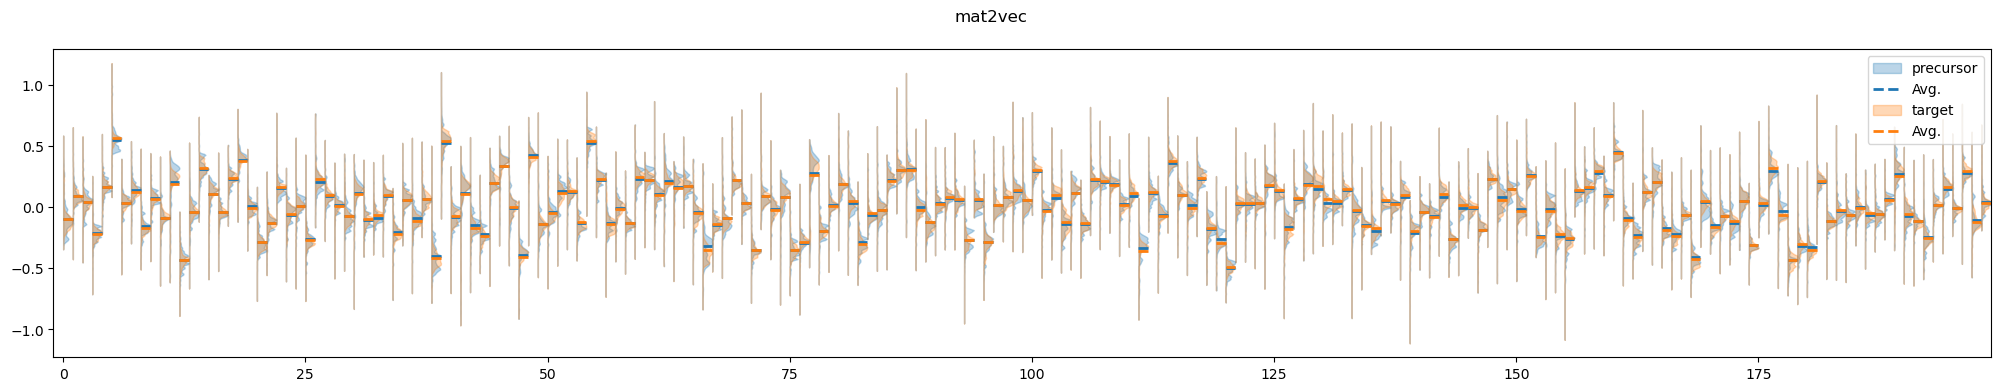

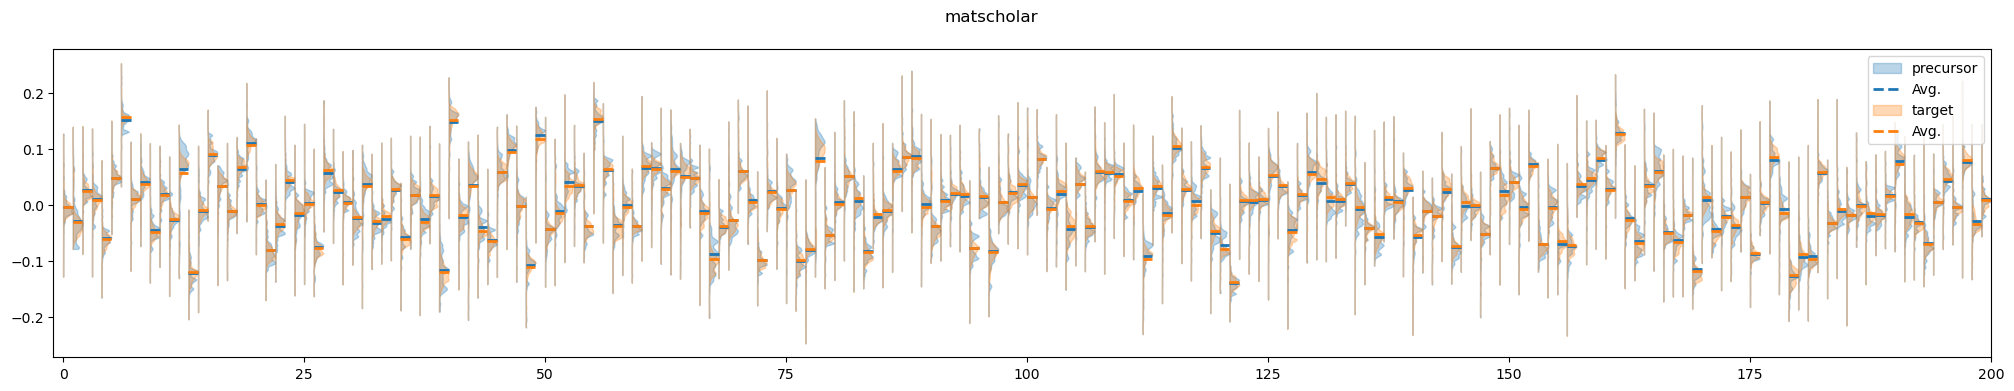

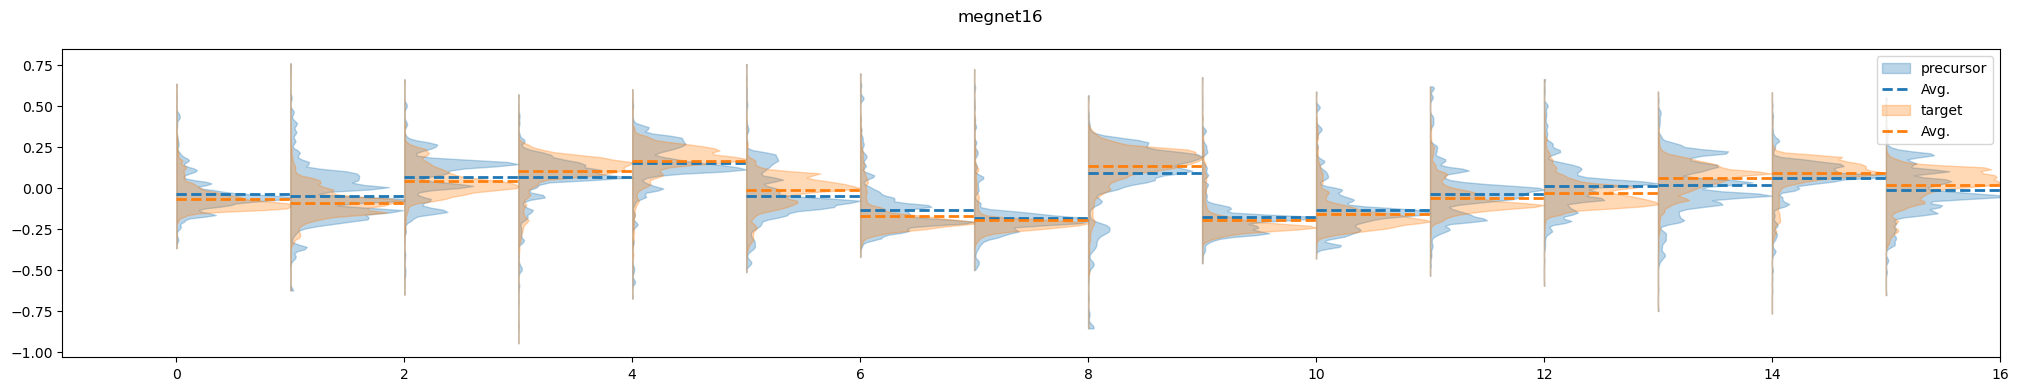

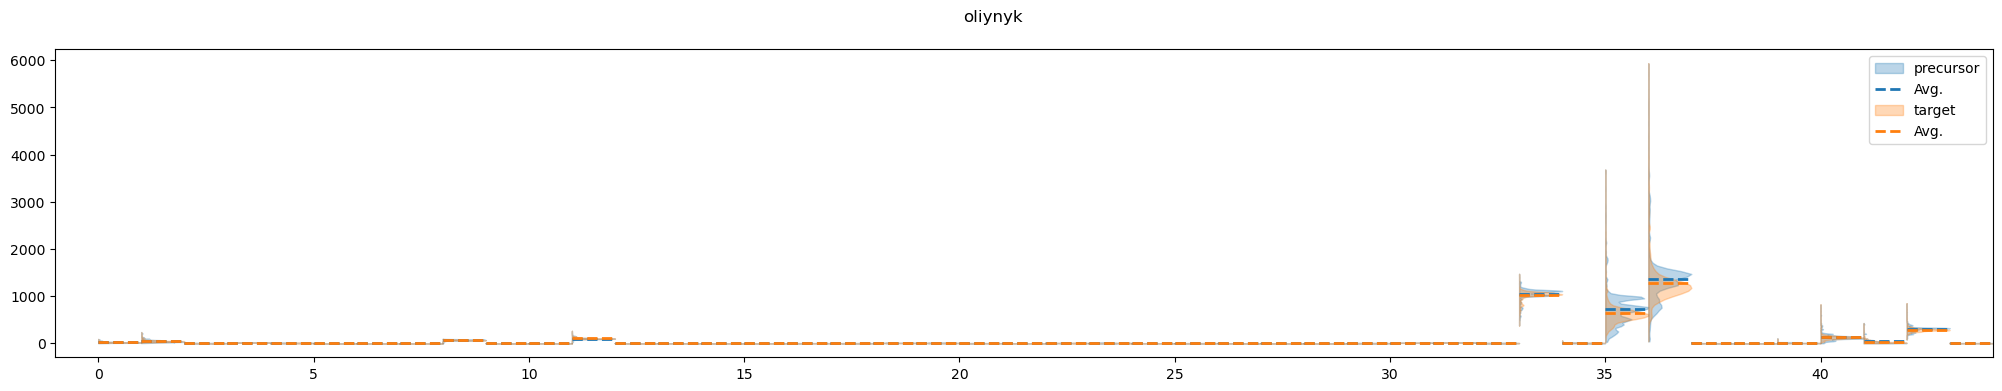

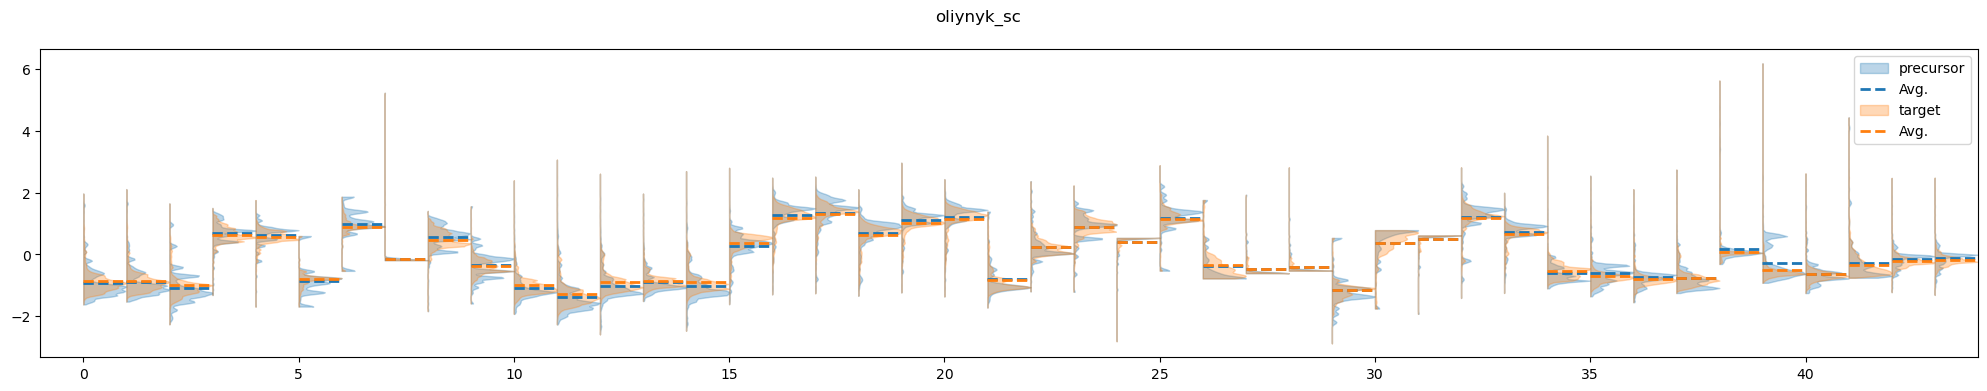

In [33]:

for feat_type in ['composit','cgcnn','elemnet','magpie','magpie_sc','mat2vec','matscholar','megnet16','oliynyk','oliynyk_sc']:
    ds = ReactionDataset(feat_type=feat_type)
    ds.from_file('../data/screened_conditional_reaction.pkl.gz')
    feat, info = ds.cfn(ds)
    n = len(ds)
    mask = np.hstack([np.zeros((n, 1), dtype=bool), (feat['label'] != EOS_LABEL)[..., :-1].cpu().numpy()]).reshape(-1)
    inps = feat['inp'].numpy().reshape(n * 8, -1)[mask].T
    conds = feat['condition'].numpy().reshape(n * 8, -1)[mask].T
    f, ax = plt.subplots(1, 1, figsize=(25, 4))
    f.suptitle(feat_type)
    for i, (inp, cond) in enumerate(zip(inps, conds)):
        ic = np.hstack([inp, cond])
        if ic.max() - ic.min() < 1e-2: continue
        y = np.linspace(ic.min(), ic.max(), 100)
        for j, (v, lbl) in enumerate(zip([inp, cond], ['precursor','target'])):
            x1 = gaussian_kde(v)(y)
            x0 = np.ones_like(y) * i
            if i == 0:
                ax.fill_betweenx(y, x0, x1 / x1.max() + i, color=plt.cm.tab10(j), alpha=0.3, label=lbl)
                ax.plot([i, i+1], [v.mean(), v.mean()], ls='--', color=plt.cm.tab10(j), lw=2, label='Avg.')
            else:
                ax.fill_betweenx(y, x0, x1 / x1.max() + i, color=plt.cm.tab10(j), alpha=0.3)
                ax.plot([i, i+1], [v.mean(), v.mean()], ls='--', color=plt.cm.tab10(j), lw=2)
    ax.legend(loc='upper right')
    ax.set_xlim([-1, i+2])

### conditions - Temp. & time

In [21]:
ds = ReactionDataset(feat_type='composit')
ds.from_file('../data/screened_conditional_reaction.pkl.gz', heat_temp_key=['heat_temp','median'])
temp_median = ds.cfn(ds)[0]['condition'][:, 0, -1]
ds.from_file('../data/screened_conditional_reaction.pkl.gz', heat_temp_key=['heat_time','median'])
time_median = ds.cfn(ds)[0]['condition'][:, 0, -1]

#### normalization

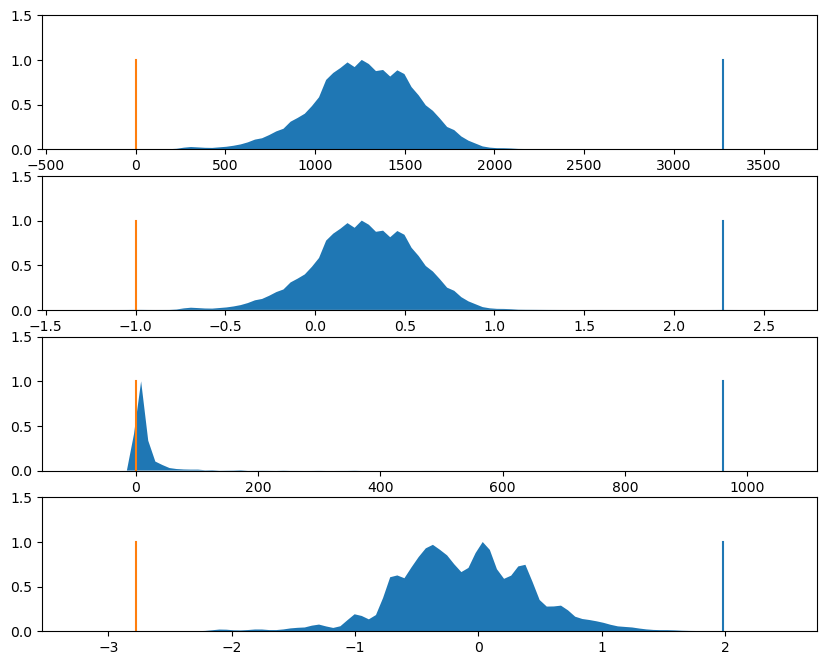

In [36]:
f, axs = plt.subplots(4, 1, figsize=(10, 8))
for i, (val, fnc) in enumerate([(temp_median, lambda x: x / 1000 - 1), 
                                (time_median, lambda x: np.log10(x) - 1)]):
    for j, v in enumerate([val.numpy(), fnc(val.numpy())]):
        vmax, vmin = v.max(), v.min()
        y = np.linspace(vmin - (vmax - vmin) * 0.1, vmax + (vmax - vmin) * 0.1, 100)
        x1 = gaussian_kde(v)(y)
        x0 = np.zeros_like(y) 
        axs[i * 2 + j].fill_between(y, x0, x1 / x1.max())
        axs[i * 2 + j].plot([vmax, vmax], [0, 1])
        axs[i * 2 + j].plot([vmin, vmin], [0, 1])
        axs[i * 2 + j].set_ylim([0, 1.5])

In [14]:
temp_median.min(), temp_mean.min(), time_median.min(), time_mean.min(),

(tensor(1.5000), tensor(1.5000), tensor(0.), tensor(0.))

# Model compatibility

## Transformers

In [147]:
import sys, torch, os
sys.path.append('..')
from src.networks import BaseNetwork, TransformerDecoderBlock
from src.data import ReactionDataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

### Dataset loading

In [148]:
train_ds = ReactionDataset()
train_ds.from_file('../data/screened_conditional_reaction.pkl.gz', heat_temp_key=('heat_temp','median'))

#### funcionalities

In [183]:
tdb = TransformerDecoderBlock(72)
tdb.device, tdb._dummy, tdb.state_dict()['target_embed_layer.weight']

(device(type='cpu'),
 tensor([0]),
 tensor([[-0.7660,  0.3099,  2.1681,  ...,  1.4449, -0.7607, -1.8575],
         [ 0.0193, -0.1830, -1.1914,  ...,  0.1452,  1.4415, -0.1057],
         [ 0.2274, -0.8929,  1.2208,  ...,  1.5936, -1.2924, -1.0464],
         ...,
         [-0.6182, -1.7984, -0.3886,  ...,  0.5138, -0.0936,  1.2494],
         [ 2.7026,  0.1017, -0.6171,  ..., -0.6383, -0.2152,  0.7330],
         [-0.8388,  1.5984, -1.4492,  ..., -0.1549, -1.3224,  0.9043]]))

In [185]:
tdb.to('cuda')
#tdb._dummy = torch.tensor([0])
#tdb._dummy.to('cuda')
#tdb.positional_encoding.pe = tdb.positional_encoding.pe.to('cuda')
tdb.positional_encoding.pe

super?


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  5.3317e-01,  ...,  1.0000e+00,
          1.7783e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.0213e-01,  ...,  1.0000e+00,
          3.5566e-04,  1.0000e+00],
        ...,
        [ 3.7961e-01, -9.2515e-01, -9.0865e-01,  ...,  9.9953e-01,
          1.7248e-02,  9.9985e-01],
        [-5.7338e-01, -8.1929e-01, -9.9136e-01,  ...,  9.9952e-01,
          1.7426e-02,  9.9985e-01],
        [-9.9921e-01,  3.9821e-02, -7.6875e-01,  ...,  9.9951e-01,
          1.7604e-02,  9.9985e-01]], device='cuda:0')

#### positional encoding test

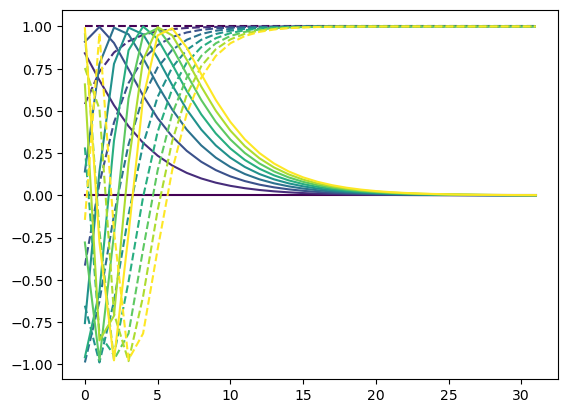

In [136]:
max_len = 100
hidden_dim = 64

pe = torch.zeros(1, max_len, hidden_dim)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-np.log(10000.0) / hidden_dim))
pe[..., 0::2] = torch.sin(position * div_term)
pe[..., 1::2] = torch.cos(position * div_term)
for i in range(9):
    plt.plot(pe[0,i,::2], color=plt.cm.viridis(i/8))
    plt.plot(pe[0,i,1::2], ls='--', color=plt.cm.viridis(i/8))

0.0


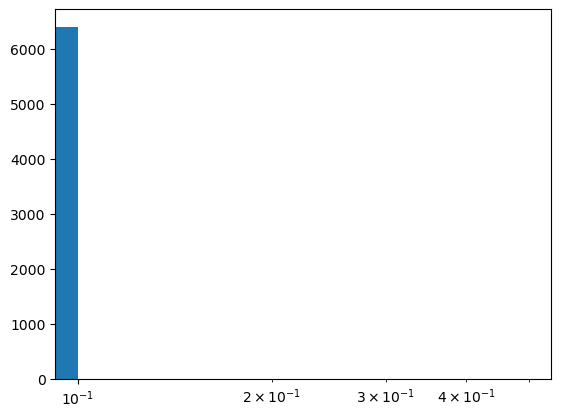

In [143]:
pec = PositionalEncoding(hidden_dim)
print(np.max(np.abs(pec(100)[0].numpy() - pe.numpy()[0]).reshape(-1)))
plt.hist(np.abs(pec(100)[0].numpy() - pe.numpy()[0]).reshape(-1))
plt.xscale('log')

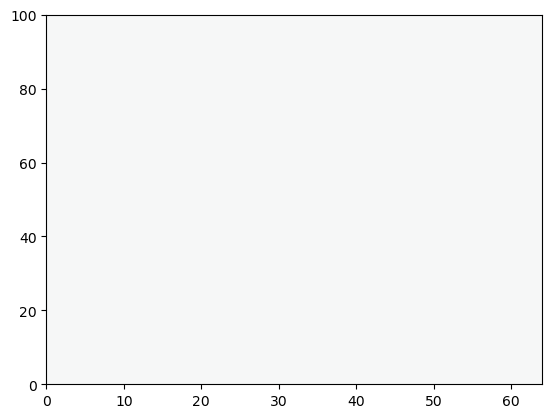

In [140]:
plt.pcolormesh(pec(100)[0].numpy() - pe.numpy()[0], cmap='RdBu', vmin=-1e-6, vmax=1e-6)

In [11]:
feat, info = train_ds.cfn(train_ds[:10])

In [9]:
test = []
for d in train_ds[:10]:
    test.append(d.precursor_feat)

torch.concat(test).shape
#d.precursor_feat.shape
#d.weights

torch.Size([10, 8, 97])

In [33]:
y = x + out[1]
y[9]

tensor([[ 9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,
          9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,
          9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,
          9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000,  9.0000, 10.0000],
        [ 9.8415,  9.5403,  9.5332,  9.8460,  9.3110,  9.9504,  9.1769,  9.9842,
          9.0998,  9.9950,  9.0562,  9.9984,  9.0316,  9.9995,  9.0178,  9.9998,
          9.0100, 10.0000,  9.0056, 10.0000,  9.0032, 10.0000,  9.0018, 10.0000,
          9.0010, 10.0000,  9.0006, 10.0000,  9.0003, 10.0000,  9.0002, 10.0000],
        [ 9.9093,  8.5839,  9.9021,  9.4315,  9.5911,  9.8066,  9.3482,  9.9374,
          9.1987,  9.9801,  9.1122,  9.9937,  9.0632,  9.9980,  9.0356,  9.9994,
          9.0200,  9.9998,  9.0112,  9.9999,  9.0063, 10.0000,  9.0036, 10.0000,
          9.0020, 10.0000,  9.0011, 10.0000,  9.0006, 10.0000,  9.0004, 10.0000],
        [ 9.1411,  8.0100

- forwarding test

In [145]:
Model = TransformerDecoderBlock(NUM_LABEL, 98)
out = Model(feat['labels'], feat['conditions'])
#out[1]
#out[1].shape
#
#x = torch.ones(10, 8, 32) * torch.arange(0, 10, 1).view(-1,1,1)

- generation test

In [146]:
context = feat['conditions']

output_seq = torch.ones(context.shape[0], 1).long() * SOS_LABEL
for i in range(5):
    o = Model(output_seq, feat['conditions'])
    output_seq = torch.hstack([output_seq, o.argmax(-1)[:, -1:]])
output_seq

tensor([[443,  57,  47, 316,  47, 229],
        [443, 359, 286, 382, 207, 176],
        [443, 296, 100,  45, 278, 236],
        [443, 318, 360, 175, 202,  45],
        [443, 296, 100, 320, 137, 333],
        [443, 296, 100, 443, 364,  29],
        [443, 296, 296, 120,   8, 192],
        [443, 265, 380, 236, 357,  70],
        [443, 296,  70, 179, 300,  20],
        [443, 359, 300,  82, 306, 335]])

## LSTM

- done in sequence.ipynb file

## CVAE

In [2]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDS = ReactionGraphDataset()
GDS.from_file('../data/screened_conditional_reaction.pkl.gz', 
              heat_temp_key=('heat_temp','median'))

DS = ReactionDataset()
DS.from_file('../data/screened_conditional_reaction.pkl.gz', 
             heat_temp_key=('heat_temp','median'))


### graph

In [34]:
years = np.array([d.year for d in GDS])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDS, batch_size=128, sampler=SubsetRandomSampler(train_idx), collate_fn=GDS.cfn)
valid_dl = DataLoader(GDS, batch_size=2048, sampler=valid_idx, collate_fn=GDS.cfn)
test_dl = DataLoader(GDS, batch_size=2048, sampler=test_idx, collate_fn=GDS.cfn)

# model = GraphCVAE(
#     input_dim=GDS.num_precursor_feat, latent_dim=16, 
#     condition_dim=GDS.num_meta_feat + GDS.has_temp_info + GDS.has_time_info, 
#     edge_dim=GDS.num_edge_feat, output_dim=GDS.NUM_LABEL, graph='atten',
#     encoder_hidden_dim=128, encoder_hidden_layers=3,
#     decoder_hidden_dim=128, decoder_hidden_layers=3,
#     batch_norm=False, dropout=0.3,
# )

model = GraphConvolutionBlock(
    input_dim=GDS.num_meta_feat + GDS.has_temp_info + GDS.has_time_info,
    edge_dim=GDS.num_edge_feat, output_dim=GDS.NUM_LABEL, 
    hidden_dim=128, hidden_layers=4,
    batch_norm=True, dropout=0.0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
#                         output_keys=['pred','kld','mu','log_var','z']
                         output_keys=['pred']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, *args, **kwargs):
        _feat, _ = batch
        x = _feat['condition'].to('cuda')
        edge_attr = _feat['edge_attr'].to('cuda')
        edge_index = _feat['edge_index'].to('cuda')
        pred = self.model(x=x, edge_attr=edge_attr, edge_index=edge_index)
        output = [pred.detach()]
        # pred, kld, l, z = self.model(x=x, edge_attr=edge_attr, edge_index=edge_index)
        # mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        # output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            alpha = (label[_feat['label_mask']] - 0.25).abs()
#            ce_loss = (self.crit(pred, feat['label']) * (feat['label_mask'] + 1e-4)).mean()
            bce_loss = self.crit(pred, label)[_feat['label_mask']]
            loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
#            mse = torch.mean(torch.sum(torch.square(feat['x'] - pvec), -1))
            # loss = ce_loss + beta * kld.sum()
            return loss.mean(), output
        else:
            return output

tr = TestTR(model, lr=1e-4, crit=torch.nn.BCEWithLogitsLoss(reduction='none'))
best_valid_loss = 1e5
count = 0
for i in range(100):
    # for j, batch in enumerate(train_dl):
    #     _loss, _output = tr._eval_batch(batch, True, 1e-4)
    #     if _loss.isnan().item(): break
    #     tr.opt.zero_grad()
    #     _loss.backward()
    #     tr.opt.step()
    # if _loss.isnan().item(): break
    train_loss = tr.train(train_dl)
    valid_loss, valid_output = tr.test(valid_dl)
    test_loss, test_output = tr.test(test_dl)
    if valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    if count > 25:
        break
    # print('{:4d} / {:8.4f} {:8.4f} {:8.4f} / {:10.4f} {:10.4f}'.format(
    #     i, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 /   0.01369102   0.00695609   0.00955437
   1 /   0.00613806   0.00613061   0.00924648
   2 /   0.00558596   0.00580609   0.00887350
   3 /   0.00531612   0.00566893   0.00867246
   4 /   0.00513911   0.00562945   0.00868934
   5 /   0.00501226   0.00555924   0.00897166
   6 /   0.00490138   0.00566721   0.00872526
   7 /   0.00480943   0.00566076   0.00911825
   8 /   0.00472113   0.00553858   0.00851484
   9 /   0.00464416   0.00546997   0.00877933
  10 /   0.00457672   0.00561322   0.00864385
  11 /   0.00451360   0.00584160   0.00884632
  12 /   0.00444698   0.00574068   0.00932843
  13 /   0.00438907   0.00573481   0.00874863
  14 /   0.00432003   0.00587557   0.00851895
  15 /   0.00425058   0.00573623   0.00902800
  16 /   0.00420642   0.00586105   0.00876731
  17 /   0.00414508   0.00599265   0.00903767
  18 /   0.00410561   0.00571754   0.00882160
  19 /   0.00405267   0.00590058   0.00919816
  20 /   0.00400657   0.00603679   0.00928797
  21 /   0.00395051   0.00593844  

KeyboardInterrupt: 

In [25]:
label = batch[0]['label'][batch[0]['label_mask']]


tensor([0.9000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000])

##### attention graph CVAE

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_accuracy(th, output):
    pred = torch.nn.Sigmoid()(torch.from_numpy(np.vstack(output['pred']))).numpy()
    label = np.vstack(output['label']).astype(bool)
    mask = np.vstack(output['label_mask'])
    n = 0
    rxn_ids = []
    for rxn_id in output['rxn_id']:
        rxn_ids.append(rxn_id + n - rxn_id.min())
        n = rxn_id.max() + 1
    rxn_ids = np.hstack(rxn_ids)
    by_rxn = []
    rxn = []
    lbls = []
    prds = []
    rxn_id = 0
    for _p, l, m, i in zip(pred, label, mask, rxn_ids):
        p = _p > th
        if p[m].sum() == 0:
            p[m][_p[m].argmax()] = True
        _m = (p | l) & m
        lbls.append(l[_m])
        prds.append(p[_m])
        if i == rxn_id:
            rxn.append((l & p)[_m])
        else:
            by_rxn.append(np.hstack(rxn).mean() == 1)
            rxn = [(l & p)[_m]]
            rxn_id = i
    labels = np.hstack(lbls)
    preds = np.hstack(prds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    rxn_acc = np.hstack(by_rxn).mean()
    return precision, recall, f1, rxn_acc

_output = {}

In [38]:
ths = np.linspace(0,1,101)

_output['focal_loss2'] = []
for th in ths:
    _output['focal_loss2'].append(compute_accuracy(th, best_valid_output))

/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: __init__() got an unexpected keyword argument 'n_col'

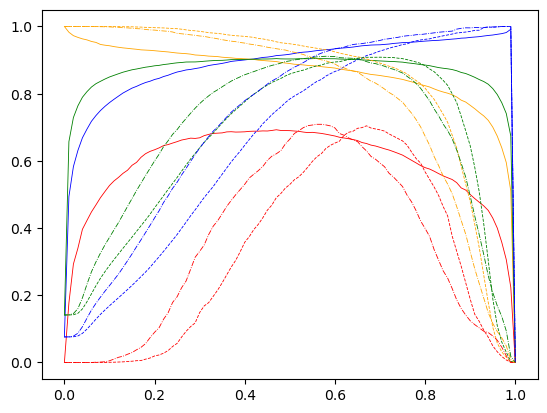

In [48]:
f, ax = plt.subplots(1,1,figsize=(10,5))
for v, c in zip(np.array(_output['graph']), ['blue','orange','green','red']):
    ax.plot(ths, v, color=c, lw=0.6)
    print(f'{v.max():.4f}')
print()
for v, c in zip(np.array(_output['focal_loss']).T, ['blue','orange','green','red']):
    ax.plot(ths, v, color=c, ls='--', lw=0.6)
    print(f'{v.max():.4f}')
print()
for v, c in zip(np.array(_output['focal_loss2']).T, ['blue','orange','green','red']):
    ax.plot(ths, v, color=c, ls='-.', lw=0.6)
    print(f'{v.max():.4f}')
print()
ax.legend(loc='lower center', n_col=3)

In [194]:
_feat, _ = next(iter(valid_dl))
x = _feat['condition'].to('cuda')
edge_attr = _feat['edge_attr'].to('cuda')
edge_index = _feat['edge_index'].to('cuda')
pred = model(x=x, edge_attr=edge_attr, edge_index=edge_index)


In [197]:
pred.shape, _feat['label'].shape, _feat['label_mask'].shape


(torch.Size([8444, 94]), torch.Size([8444, 94]), torch.Size([8444, 94]))

In [148]:
(p[m] > 0.3) == l[m]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [122]:
np.mean([True, True, True]) == 1

True

In [72]:
batch = next(iter(valid_dl))
batch[0]['rxn_id']

array([   0,    0,    0, ..., 2047, 2047, 2047])

In [162]:
for k,v in tr.model.state_dict().items():
    print(k, v.shape, v.isnan().sum().item())

encoder.input_embed_layer.0.weight torch.Size([128, 88]) 0
encoder.input_embed_layer.0.bias torch.Size([128]) 0
encoder.input_embed_layer.1.weight torch.Size([128]) 0
encoder.input_embed_layer.1.bias torch.Size([128]) 0
encoder.input_embed_layer.1.running_mean torch.Size([128]) 0
encoder.input_embed_layer.1.running_var torch.Size([128]) 0
encoder.input_embed_layer.1.num_batches_tracked torch.Size([]) 0
encoder.edge_embed_layer.0.weight torch.Size([128, 88]) 0
encoder.edge_embed_layer.0.bias torch.Size([128]) 0
encoder.edge_embed_layer.1.weight torch.Size([128]) 0
encoder.edge_embed_layer.1.bias torch.Size([128]) 0
encoder.edge_embed_layer.1.running_mean torch.Size([128]) 0
encoder.edge_embed_layer.1.running_var torch.Size([128]) 0
encoder.edge_embed_layer.1.num_batches_tracked torch.Size([]) 0
encoder.graph_layer.module_0.lin_f.weight torch.Size([128, 384]) 0
encoder.graph_layer.module_0.lin_f.bias torch.Size([128]) 0
encoder.graph_layer.module_0.lin_s.weight torch.Size([128, 384]) 0
e

In [208]:
tr._eval_batch(batch)

(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>),
 [array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
  array([[9.75974219e+04],
         [6.70671400e+07],
         [1.75873420e+07],
         [5.13133750e+06],
         [2.65350812e+05],
         [1.37001950e+06],
         [1.78046218e+15],
         [8.02177295e+19],
         [3.09110516e+13],
         [1.90115799e+21],
         [4.18764565e+21],
         [1.32772762e+06],
         [2.75677312e+05],
         [9.82551900e+06],
         [7.13165000e+05],
         [2.21670660e+07],
         [4.46848375e+05],
         [1.51440859e+05],
         [4.33390650e+06],
         [6.59602812e+05],
         [2.35915172e+05],
         [2.82367565e+09],
         [2.74796493e+09],
         [3.9349

In [165]:
tr.model(**{k:v.to('cuda') for k,v in batch[0].items() if isinstance(v, torch.Tensor)})

(tensor([[ -2.3544, -11.4971,   7.9738,  ...,  -4.4198,   3.3422,   8.2587],
         [ -7.1815,   1.2130,  -6.0242,  ..., -13.1098,  -8.3219,  -6.2423],
         [  7.4777,  -3.2992,   0.3620,  ...,   3.3161,  -1.1008,  -4.2035],
         ...,
         [  0.3667,   1.9243,   2.8497,  ...,  -3.5732,  -5.7450,  -2.6942],
         [ -2.4912,  -4.6199,  -4.9320,  ...,  -1.8241,   1.5638,   2.8206],
         [ -2.1257,   0.2326,  -0.4018,  ...,  -4.2316,  -4.2298,  -6.4264]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[6.2216e+06],
         [2.5016e+10],
         [4.4190e+18],
         [1.0740e+14],
         [1.0689e+19],
         [4.0309e+05],
         [6.7974e+07],
         [1.5760e+04],
         [7.4351e+08],
         [5.5051e+07],
         [1.6633e+11],
         [2.3743e+13],
         [3.7155e+06],
         [7.3810e+03],
         [4.8322e+09],
         [2.4130e+11],
         [8.9925e+03],
         [1.5015e+06],
         [6.6989e+05],
         [1.1315e+09],
         [9

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [46]:
crit = torch.nn.BCEWithLogitsLoss(reduction='none')
crit(p, batch[0]['label'])[batch[0]['label_mask']].mean()


(torch.Size([1008, 1]), torch.Size([1008, 94]))

In [124]:
model = GraphCVAE(
    input_dim=GDS.num_precursor_feat, latent_dim=2, 
    condition_dim=GDS.num_meta_feat + GDS.has_temp_info + GDS.has_time_info, 
    edge_dim=GDS.num_edge_feat, output_dim=GDS.NUM_LABEL, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=False, dropout=0.4,
)

batch = next(iter(train_dl))
p, kld, _, _ = model(**batch[0])
kld.max()

tensor(2.9135e+33, grad_fn=<MaxBackward1>)

In [59]:
latent space로 인한 KLD의 발산이 문제임

(tensor([[ 39.5093,   3.8471,  15.0651,  ..., -11.8016,   1.1539,  -3.4391],
         [  7.8399,  -4.2669,  38.1090,  ...,   8.3803,   9.4149,   3.4675],
         [  4.4796, -16.7567,  16.5849,  ...,   5.3763,   3.5464, -13.7563],
         ...,
         [  2.7636,   4.8044,   1.8202,  ...,   0.9122,   4.5525,  -4.2126],
         [ 10.1455,   7.8006,   5.4093,  ...,  -5.3851,   1.1713,  -3.3818],
         [  5.2224,   1.6117,   2.4887,  ...,  -1.6828,   4.1672,   0.7225]],
        grad_fn=<AddmmBackward0>),
 tensor(inf, grad_fn=<MaxBackward1>))

In [20]:
model.encoder.state_dict()

OrderedDict([('input_embed_layer.0.weight',
              tensor([[nan, nan, nan,  ..., nan, nan, nan],
                      [nan, nan, nan,  ..., nan, nan, nan],
                      [nan, nan, nan,  ..., nan, nan, nan],
                      ...,
                      [nan, nan, nan,  ..., nan, nan, nan],
                      [nan, nan, nan,  ..., nan, nan, nan],
                      [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')),
             ('input_embed_layer.0.bias',
              tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                      nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                      nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                      nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [13]:
for batch in test_dl:
    output = model(**batch[0])

In [33]:
from src.trainer import VAETrainer

class VAEMaskedClassTrainer(VAETrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.BCEWithLogitsLoss(reduction='none')):
        super().__init__(model, lr, device)
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.1):
        feat, _ = batch
        pred, kld, l, z = self.model(**feat)
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        output = [pred.detach().cpu().numpy(), kld.detach().cpu().numpy(), mu.numpy(), log_var.exp().numpy(), z.detach().cpu().numpy()]
        if compute_loss:
            bce_loss = self.crit(pred, feat['label'])[feat['label_mask']].mean()
            loss = bce_loss + beta * kld.sum()
            return loss, output
        else:
            return output


In [37]:
crit1 = torch.nn.BCEWithLogitsLoss(reduction='none')
crit2 = torch.nn.BCELoss(reduction='none')

feat, info = next(iter(valid_dl))

y = feat['label'].float()
x = torch.zeros_like(y)
loss = crit1(x, y)[feat['label_mask']]

In [42]:
loss.shape, 8444 * 94, crit1(x, y).view(-1)[feat['label_mask'].view(-1)].shape

(torch.Size([87472]), 793736, torch.Size([87472]))

In [25]:
x

tensor([[0.2952, 0.1075, 0.9114,  ..., 0.2155, 0.8906, 0.5665],
        [0.1698, 0.5313, 0.5133,  ..., 0.1629, 0.7227, 0.6214],
        [0.9103, 0.6088, 0.5039,  ..., 0.2255, 0.6117, 0.1699],
        ...,
        [0.6622, 0.2026, 0.8518,  ..., 0.6953, 0.3615, 0.2520],
        [0.6242, 0.4729, 0.4525,  ..., 0.3546, 0.5906, 0.2484],
        [0.7129, 0.3496, 0.7523,  ..., 0.3288, 0.3215, 0.5368]])

In [2]:


years = np.array([d.year for d in DS])
DS.to('cuda')
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(DS, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=DS.cfn)
valid_dl = DataLoader(DS, batch_size=2048, sampler=valid_idx, collate_fn=DS.cfn)
test_dl = DataLoader(DS, batch_size=2048, sampler=valid_idx, collate_fn=DS.cfn)

model = DNNCVAE(DS.num_ligand_feat, 16, DS.num_target_feat + DS.num_metal_feat,
                encoder_hidden_dim=128, encoder_hidden_layers=4,
                decoder_hidden_dim=128, decoder_hidden_layers=4)

tr = VAETrainer(model, 1e-5)

path = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE/dnn_16_cgcnn_test'
os.makedirs(path, exist_ok=True)
writer = SummaryWriter(path)
for i in range(50):
    train_loss = tr.train(train_dl)
    writer.add_scalar('Loss/Train', train_loss, i+1)
    valid_loss, valid_output = tr.test(valid_dl)
    test_loss, test_output = tr.test(test_dl)

    writer.add_scalar('Loss/Valid', valid_loss, i+1)
    writer.add_scalar('Loss/Test', test_loss, i+1)
    writer.add_scalar('KLD/Valid', valid_output['kld'], i+1)
    writer.add_scalar('KLD/Test', test_output['kld'], i+1)


In [4]:
from src.feature import feature_to_composit, ligand_label
def feature_to_ligand_index(feat_vec, tol=0.5):
    comps = feature_to_composit(feat_vec, tol)
    out = []
    for comp in comps:
        eles = '-'.join(comp.keys())
        i = ligand_label.get(eles)
        out.append(-1 if i is None else i)
    return out

inp = feature_to_ligand_index(valid_output['input'])
prd = feature_to_ligand_index(valid_output['pred'])

In [11]:
from sklearn.metrics import confusion_matrix


array([[   0,    0,    0, ...,    0,    0,    0],
       [   0, 8313,  120, ...,    0,    0,    0],
       [   0,  230, 2259, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   1,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [52]:

def _feature_to_composit(feat_vec, tol=0.5, to_string=False, to_idx=False):
    n_feat = feat_vec.shape[-1]
    if n_feat not in [97, 87, 12]:
        raise TypeError(f'feature type is not supported', composit_fnc)
    if n_feat == 97: # active_composit
        ref = ActiveElements
    elif n_feat == 87: # metal_composit
        ref = ['None'] + MetalElements
    elif n_feat == 12: # ligand_composit
        ref = ['Metal'] + LigandElements
    mask = feat_vec > tol
    out = [tuple([ref[i] for i in np.where(vec)[0]]) for vec in mask]
    if to_string or to_idx:
        out = ['-'.join(o) for o in out]
    if to_idx:
        out = [ligand_label[o] if o in ligand_label.keys() else -1 for o in out]
    return out


In [70]:
from sklearn.metrics import f1_score

f1_score(inp, prd, average='micro')

0.9063270336894002

In [72]:
'.'.join(ligand_label.keys())

'Metal-O.Metal-C-O.Metal.Metal-H-O.Metal-N-O.Se.H-N-O-P.S.Metal-H-C-O.Metal-F.Metal-S.Metal-N.Metal-Cl.Metal-H-N-O.Metal-O-P.Metal-H-O-P.P.Metal-Se.C.O-P.Metal-I.Metal-O-S.H-O-P.Metal-Br.Metal-C.Metal-H.H-C-O.H-N-Cl.P-S.Metal-H-N.P-Se.Metal-P.H-N-F.Metal-O-Cl.O-Se.I.H-N-O-S.Metal-C-N.H-O-S.Metal-H-N-O-P.H-N-Br.H-C-S-I.Metal-O-Br.H-C-S-Cl.H-C-S-Br.Metal-C-S.Metal-O-Se.Metal-H-N-Cl.Metal-P-S-Se.H-C-N-S.Metal-O-F-P.N-P.Cl.Metal-P-S.Metal-H-N-O-S.H-Cl.Metal-H-O-S.H-C.Metal-H-C-N-O-P.H-C-N-O.Metal-H-F.Br.Metal-O-F.H-N-O.H-O-Se.Metal-H-Cl.H-S.C-N-S.Metal-O-I.H-C-N.Metal-O-P-Cl.Metal-H-O-Cl.Metal-P-S-Br.H-C-N-Cl.Metal-H-C-N-Cl.H-C-N-I.Metal-H-C-N-I.Metal-H-C-N-Br.Metal-S-Se'

In [6]:
import sys
sys.path.append('..')
from src.data import ReactionDataset
from src.feature import init_info

init_info(0)
rd = ReactionDataset(precursor_feat_type='active_composit')
rd.from_file()
len(rd)

31387

In [3]:
rd.to('cpu')
feat, info = rd.cfn(rd)

In [4]:
import numpy as np
np.unique(feat['label'].numpy(), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177